In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer

In [2]:
afq_dataset = AFQDataset(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md"],
    target_cols=["age"],
    index_col="subject_id",
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1867
(1867, 4800)
(1867,)


In [5]:
# Here we impute missing bundles.
# We impute using the entire dataset, which permits data leakage between the train and test set.
# THIS IS BAD AND SHOULDN'T BE DONE IN PRODUCTION
# But we do it here to move straight to model training
# When we are more comfortabel with the models, we should come back
# here and train the imputer only on the training set.
imputer = SimpleImputer(strategy="median")
afq_dataset.X = imputer.fit_transform(afq_dataset.X)

In [6]:
# Separate into training, test, and validation sets
dataset_size = len(afq_dataset.subjects)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

full_dataset = afq_dataset.as_tensorflow_dataset()
full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=0)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

2022-01-25 18:23:45.833372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [24]:
# First let's check out the ``cnn_lenet`` from the tf_models module
model_cnn_lenet= cnn_lenet(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)

# Compile the model and fit it using training data
model_cnn_lenet.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_cnn_lenet.fit(train_dataset, epochs=5000, validation_data=val_dataset)

pooling layers: 4
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 conv1d_20 (Conv1D)          (None, 100, 6)            870       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 25, 2

Epoch 34/5000
11/11 [==============================] - 0s 25ms/step - loss: 17.5977 - mean_squared_error: 17.5977 - val_loss: 12.0999 - val_mean_squared_error: 12.0999
Epoch 35/5000
11/11 [==============================] - 0s 25ms/step - loss: 16.7733 - mean_squared_error: 16.7733 - val_loss: 10.8121 - val_mean_squared_error: 10.8121
Epoch 36/5000
11/11 [==============================] - 0s 25ms/step - loss: 17.0906 - mean_squared_error: 17.0906 - val_loss: 10.7588 - val_mean_squared_error: 10.7588
Epoch 37/5000
11/11 [==============================] - 0s 25ms/step - loss: 17.2751 - mean_squared_error: 17.2751 - val_loss: 12.2131 - val_mean_squared_error: 12.2131
Epoch 38/5000
11/11 [==============================] - 0s 25ms/step - loss: 16.5936 - mean_squared_error: 16.5936 - val_loss: 12.2126 - val_mean_squared_error: 12.2126
Epoch 39/5000
11/11 [==============================] - 0s 25ms/step - loss: 17.8575 - mean_squared_error: 17.8575 - val_loss: 10.8709 - val_mean_squared_error: 

11/11 [==============================] - 0s 25ms/step - loss: 11.4726 - mean_squared_error: 11.4726 - val_loss: 7.9472 - val_mean_squared_error: 7.9472
Epoch 84/5000
11/11 [==============================] - 0s 25ms/step - loss: 11.8293 - mean_squared_error: 11.8293 - val_loss: 6.5909 - val_mean_squared_error: 6.5909
Epoch 85/5000
11/11 [==============================] - 0s 25ms/step - loss: 11.6629 - mean_squared_error: 11.6629 - val_loss: 9.0821 - val_mean_squared_error: 9.0821
Epoch 86/5000
11/11 [==============================] - 0s 25ms/step - loss: 11.9676 - mean_squared_error: 11.9676 - val_loss: 7.8456 - val_mean_squared_error: 7.8456
Epoch 87/5000
11/11 [==============================] - 0s 25ms/step - loss: 11.4928 - mean_squared_error: 11.4928 - val_loss: 9.1156 - val_mean_squared_error: 9.1156
Epoch 88/5000
11/11 [==============================] - 0s 25ms/step - loss: 11.6870 - mean_squared_error: 11.6870 - val_loss: 8.0041 - val_mean_squared_error: 8.0041
Epoch 89/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 9.8892 - mean_squared_error: 9.8892 - val_loss: 5.8882 - val_mean_squared_error: 5.8882
Epoch 133/5000
11/11 [==============================] - 0s 25ms/step - loss: 10.1138 - mean_squared_error: 10.1138 - val_loss: 7.1680 - val_mean_squared_error: 7.1680
Epoch 134/5000
11/11 [==============================] - 0s 25ms/step - loss: 10.4059 - mean_squared_error: 10.4059 - val_loss: 6.8445 - val_mean_squared_error: 6.8445
Epoch 135/5000
11/11 [==============================] - 0s 25ms/step - loss: 10.7457 - mean_squared_error: 10.7457 - val_loss: 7.5032 - val_mean_squared_error: 7.5032
Epoch 136/5000
11/11 [==============================] - 0s 25ms/step - loss: 9.8597 - mean_squared_error: 9.8597 - val_loss: 6.3840 - val_mean_squared_error: 6.3840
Epoch 137/5000
11/11 [==============================] - 0s 25ms/step - loss: 9.8631 - mean_squared_error: 9.8631 - val_loss: 7.4835 - val_mean_squared_error: 7.4835
Epoch 138/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 8.7476 - mean_squared_error: 8.7476 - val_loss: 6.2131 - val_mean_squared_error: 6.2131
Epoch 182/5000
11/11 [==============================] - 0s 26ms/step - loss: 8.8957 - mean_squared_error: 8.8957 - val_loss: 7.1668 - val_mean_squared_error: 7.1668
Epoch 183/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.7325 - mean_squared_error: 8.7325 - val_loss: 7.0253 - val_mean_squared_error: 7.0253
Epoch 184/5000
11/11 [==============================] - 0s 25ms/step - loss: 9.5940 - mean_squared_error: 9.5940 - val_loss: 7.5345 - val_mean_squared_error: 7.5345
Epoch 185/5000
11/11 [==============================] - 0s 25ms/step - loss: 9.3859 - mean_squared_error: 9.3859 - val_loss: 6.8602 - val_mean_squared_error: 6.8602
Epoch 186/5000
11/11 [==============================] - 0s 26ms/step - loss: 9.1041 - mean_squared_error: 9.1041 - val_loss: 6.2429 - val_mean_squared_error: 6.2429
Epoch 187/5000
11/11 [===

Epoch 231/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.2232 - mean_squared_error: 8.2232 - val_loss: 6.5332 - val_mean_squared_error: 6.5332
Epoch 232/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.3491 - mean_squared_error: 8.3491 - val_loss: 6.0014 - val_mean_squared_error: 6.0014
Epoch 233/5000
11/11 [==============================] - 0s 26ms/step - loss: 8.2596 - mean_squared_error: 8.2596 - val_loss: 5.1850 - val_mean_squared_error: 5.1850
Epoch 234/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.1019 - mean_squared_error: 8.1019 - val_loss: 6.4471 - val_mean_squared_error: 6.4471
Epoch 235/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.4622 - mean_squared_error: 8.4622 - val_loss: 6.1090 - val_mean_squared_error: 6.1090
Epoch 236/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.8737 - mean_squared_error: 8.8737 - val_loss: 5.4415 - val_mean_squared_error: 5.4415
Epoch 237/

Epoch 281/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.4525 - mean_squared_error: 7.4525 - val_loss: 5.7310 - val_mean_squared_error: 5.7310
Epoch 282/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.3648 - mean_squared_error: 8.3648 - val_loss: 7.3279 - val_mean_squared_error: 7.3279
Epoch 283/5000
11/11 [==============================] - 0s 25ms/step - loss: 8.7993 - mean_squared_error: 8.7993 - val_loss: 6.5609 - val_mean_squared_error: 6.5609
Epoch 284/5000
11/11 [==============================] - 0s 26ms/step - loss: 9.2555 - mean_squared_error: 9.2555 - val_loss: 5.5257 - val_mean_squared_error: 5.5257
Epoch 285/5000
11/11 [==============================] - 0s 26ms/step - loss: 8.2395 - mean_squared_error: 8.2395 - val_loss: 5.8149 - val_mean_squared_error: 5.8149
Epoch 286/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.8628 - mean_squared_error: 7.8628 - val_loss: 6.6733 - val_mean_squared_error: 6.6733
Epoch 287/

Epoch 331/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.9670 - mean_squared_error: 7.9670 - val_loss: 5.8016 - val_mean_squared_error: 5.8016
Epoch 332/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.4436 - mean_squared_error: 7.4436 - val_loss: 5.2617 - val_mean_squared_error: 5.2617
Epoch 333/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.6332 - mean_squared_error: 7.6332 - val_loss: 5.3899 - val_mean_squared_error: 5.3899
Epoch 334/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.5894 - mean_squared_error: 7.5894 - val_loss: 5.6066 - val_mean_squared_error: 5.6066
Epoch 335/5000
11/11 [==============================] - 0s 26ms/step - loss: 7.5222 - mean_squared_error: 7.5222 - val_loss: 5.3086 - val_mean_squared_error: 5.3086
Epoch 336/5000
11/11 [==============================] - 0s 26ms/step - loss: 7.5663 - mean_squared_error: 7.5663 - val_loss: 5.3806 - val_mean_squared_error: 5.3806
Epoch 337/

Epoch 381/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.4297 - mean_squared_error: 7.4297 - val_loss: 4.5523 - val_mean_squared_error: 4.5523
Epoch 382/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.5789 - mean_squared_error: 7.5789 - val_loss: 5.4438 - val_mean_squared_error: 5.4438
Epoch 383/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.5402 - mean_squared_error: 7.5402 - val_loss: 6.2153 - val_mean_squared_error: 6.2153
Epoch 384/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.8473 - mean_squared_error: 7.8473 - val_loss: 4.7427 - val_mean_squared_error: 4.7427
Epoch 385/5000
11/11 [==============================] - 0s 26ms/step - loss: 7.2893 - mean_squared_error: 7.2893 - val_loss: 5.3926 - val_mean_squared_error: 5.3926
Epoch 386/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.0388 - mean_squared_error: 7.0388 - val_loss: 5.9868 - val_mean_squared_error: 5.9868
Epoch 387/

Epoch 431/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.0008 - mean_squared_error: 7.0008 - val_loss: 4.1007 - val_mean_squared_error: 4.1007
Epoch 432/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.8033 - mean_squared_error: 6.8033 - val_loss: 4.1052 - val_mean_squared_error: 4.1052
Epoch 433/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.8363 - mean_squared_error: 6.8363 - val_loss: 4.1769 - val_mean_squared_error: 4.1769
Epoch 434/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.0386 - mean_squared_error: 7.0386 - val_loss: 4.4469 - val_mean_squared_error: 4.4469
Epoch 435/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.2921 - mean_squared_error: 6.2921 - val_loss: 3.9331 - val_mean_squared_error: 3.9331
Epoch 436/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.6895 - mean_squared_error: 6.6895 - val_loss: 4.0704 - val_mean_squared_error: 4.0704
Epoch 437/

Epoch 481/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.9192 - mean_squared_error: 6.9192 - val_loss: 4.8850 - val_mean_squared_error: 4.8850
Epoch 482/5000
11/11 [==============================] - 0s 25ms/step - loss: 7.4390 - mean_squared_error: 7.4390 - val_loss: 3.8477 - val_mean_squared_error: 3.8477
Epoch 483/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.3015 - mean_squared_error: 6.3015 - val_loss: 4.5532 - val_mean_squared_error: 4.5532
Epoch 484/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.2164 - mean_squared_error: 6.2164 - val_loss: 4.1974 - val_mean_squared_error: 4.1974
Epoch 485/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.2017 - mean_squared_error: 6.2017 - val_loss: 4.5085 - val_mean_squared_error: 4.5085
Epoch 486/5000
11/11 [==============================] - 0s 26ms/step - loss: 6.0110 - mean_squared_error: 6.0110 - val_loss: 6.0220 - val_mean_squared_error: 6.0220
Epoch 487/

Epoch 531/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.8445 - mean_squared_error: 5.8445 - val_loss: 3.7188 - val_mean_squared_error: 3.7188
Epoch 532/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.2425 - mean_squared_error: 6.2425 - val_loss: 5.2906 - val_mean_squared_error: 5.2906
Epoch 533/5000
11/11 [==============================] - 0s 26ms/step - loss: 6.3490 - mean_squared_error: 6.3490 - val_loss: 4.2261 - val_mean_squared_error: 4.2261
Epoch 534/5000
11/11 [==============================] - 0s 25ms/step - loss: 6.1487 - mean_squared_error: 6.1487 - val_loss: 4.3824 - val_mean_squared_error: 4.3824
Epoch 535/5000
11/11 [==============================] - 0s 26ms/step - loss: 6.2335 - mean_squared_error: 6.2335 - val_loss: 4.9201 - val_mean_squared_error: 4.9201
Epoch 536/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.7505 - mean_squared_error: 5.7505 - val_loss: 3.4552 - val_mean_squared_error: 3.4552
Epoch 537/

Epoch 581/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.4146 - mean_squared_error: 5.4146 - val_loss: 3.5421 - val_mean_squared_error: 3.5421
Epoch 582/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.3511 - mean_squared_error: 5.3511 - val_loss: 3.3348 - val_mean_squared_error: 3.3348
Epoch 583/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.3130 - mean_squared_error: 5.3130 - val_loss: 3.5992 - val_mean_squared_error: 3.5992
Epoch 584/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.0196 - mean_squared_error: 5.0196 - val_loss: 3.5867 - val_mean_squared_error: 3.5867
Epoch 585/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.2174 - mean_squared_error: 5.2174 - val_loss: 4.0932 - val_mean_squared_error: 4.0932
Epoch 586/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.1693 - mean_squared_error: 5.1693 - val_loss: 3.6089 - val_mean_squared_error: 3.6089
Epoch 587/

Epoch 631/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.4323 - mean_squared_error: 5.4323 - val_loss: 4.0359 - val_mean_squared_error: 4.0359
Epoch 632/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.5935 - mean_squared_error: 5.5935 - val_loss: 3.2855 - val_mean_squared_error: 3.2855
Epoch 633/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.5765 - mean_squared_error: 5.5765 - val_loss: 3.3156 - val_mean_squared_error: 3.3156
Epoch 634/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.4771 - mean_squared_error: 5.4771 - val_loss: 2.7003 - val_mean_squared_error: 2.7003
Epoch 635/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.3264 - mean_squared_error: 5.3264 - val_loss: 3.2501 - val_mean_squared_error: 3.2501
Epoch 636/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.0749 - mean_squared_error: 5.0749 - val_loss: 3.9981 - val_mean_squared_error: 3.9981
Epoch 637/

Epoch 681/5000
11/11 [==============================] - 0s 26ms/step - loss: 4.8349 - mean_squared_error: 4.8349 - val_loss: 2.7951 - val_mean_squared_error: 2.7951
Epoch 682/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.7108 - mean_squared_error: 4.7108 - val_loss: 2.6273 - val_mean_squared_error: 2.6273
Epoch 683/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.5000 - mean_squared_error: 4.5000 - val_loss: 2.4863 - val_mean_squared_error: 2.4863
Epoch 684/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.8188 - mean_squared_error: 4.8188 - val_loss: 3.3457 - val_mean_squared_error: 3.3457
Epoch 685/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.7608 - mean_squared_error: 4.7608 - val_loss: 2.9163 - val_mean_squared_error: 2.9163
Epoch 686/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.6981 - mean_squared_error: 4.6981 - val_loss: 3.1128 - val_mean_squared_error: 3.1128
Epoch 687/

Epoch 731/5000
11/11 [==============================] - 0s 25ms/step - loss: 5.0668 - mean_squared_error: 5.0668 - val_loss: 2.7381 - val_mean_squared_error: 2.7381
Epoch 732/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.5168 - mean_squared_error: 4.5168 - val_loss: 2.5760 - val_mean_squared_error: 2.5760
Epoch 733/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.4703 - mean_squared_error: 4.4703 - val_loss: 2.9507 - val_mean_squared_error: 2.9507
Epoch 734/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.7643 - mean_squared_error: 4.7643 - val_loss: 2.4935 - val_mean_squared_error: 2.4935
Epoch 735/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.5415 - mean_squared_error: 4.5415 - val_loss: 2.8196 - val_mean_squared_error: 2.8196
Epoch 736/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.4743 - mean_squared_error: 4.4743 - val_loss: 2.4337 - val_mean_squared_error: 2.4337
Epoch 737/

Epoch 781/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.3526 - mean_squared_error: 4.3526 - val_loss: 2.4375 - val_mean_squared_error: 2.4375
Epoch 782/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.3463 - mean_squared_error: 4.3463 - val_loss: 2.8761 - val_mean_squared_error: 2.8761
Epoch 783/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.3415 - mean_squared_error: 4.3415 - val_loss: 3.4855 - val_mean_squared_error: 3.4855
Epoch 784/5000
11/11 [==============================] - 0s 26ms/step - loss: 5.0265 - mean_squared_error: 5.0265 - val_loss: 2.6385 - val_mean_squared_error: 2.6385
Epoch 785/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.2326 - mean_squared_error: 4.2326 - val_loss: 2.0523 - val_mean_squared_error: 2.0523
Epoch 786/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.2649 - mean_squared_error: 4.2649 - val_loss: 2.0555 - val_mean_squared_error: 2.0555
Epoch 787/

Epoch 831/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.1036 - mean_squared_error: 4.1036 - val_loss: 2.2715 - val_mean_squared_error: 2.2715
Epoch 832/5000
11/11 [==============================] - 0s 26ms/step - loss: 4.0825 - mean_squared_error: 4.0825 - val_loss: 2.4259 - val_mean_squared_error: 2.4259
Epoch 833/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.9950 - mean_squared_error: 3.9950 - val_loss: 1.9800 - val_mean_squared_error: 1.9800
Epoch 834/5000
11/11 [==============================] - 0s 26ms/step - loss: 4.1380 - mean_squared_error: 4.1380 - val_loss: 2.0571 - val_mean_squared_error: 2.0571
Epoch 835/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.5620 - mean_squared_error: 3.5620 - val_loss: 2.2999 - val_mean_squared_error: 2.2999
Epoch 836/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.2052 - mean_squared_error: 4.2052 - val_loss: 2.1062 - val_mean_squared_error: 2.1062
Epoch 837/

Epoch 881/5000
11/11 [==============================] - 0s 26ms/step - loss: 4.2292 - mean_squared_error: 4.2292 - val_loss: 2.3686 - val_mean_squared_error: 2.3686
Epoch 882/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.0476 - mean_squared_error: 4.0476 - val_loss: 1.8601 - val_mean_squared_error: 1.8601
Epoch 883/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.7184 - mean_squared_error: 3.7184 - val_loss: 1.8168 - val_mean_squared_error: 1.8168
Epoch 884/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.7179 - mean_squared_error: 3.7179 - val_loss: 2.6704 - val_mean_squared_error: 2.6704
Epoch 885/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.8971 - mean_squared_error: 3.8971 - val_loss: 2.6510 - val_mean_squared_error: 2.6510
Epoch 886/5000
11/11 [==============================] - 0s 26ms/step - loss: 4.2017 - mean_squared_error: 4.2017 - val_loss: 1.9799 - val_mean_squared_error: 1.9799
Epoch 887/

Epoch 931/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.2780 - mean_squared_error: 3.2780 - val_loss: 1.5063 - val_mean_squared_error: 1.5063
Epoch 932/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.5787 - mean_squared_error: 3.5787 - val_loss: 1.7909 - val_mean_squared_error: 1.7909
Epoch 933/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.5108 - mean_squared_error: 3.5108 - val_loss: 1.6616 - val_mean_squared_error: 1.6616
Epoch 934/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.2510 - mean_squared_error: 3.2510 - val_loss: 1.9063 - val_mean_squared_error: 1.9063
Epoch 935/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.5057 - mean_squared_error: 3.5057 - val_loss: 1.4729 - val_mean_squared_error: 1.4729
Epoch 936/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.2320 - mean_squared_error: 3.2320 - val_loss: 1.6944 - val_mean_squared_error: 1.6944
Epoch 937/

Epoch 981/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.7032 - mean_squared_error: 3.7032 - val_loss: 1.2888 - val_mean_squared_error: 1.2888
Epoch 982/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.5568 - mean_squared_error: 3.5568 - val_loss: 1.7263 - val_mean_squared_error: 1.7263
Epoch 983/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.6435 - mean_squared_error: 3.6435 - val_loss: 1.8705 - val_mean_squared_error: 1.8705
Epoch 984/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.3821 - mean_squared_error: 3.3821 - val_loss: 1.7493 - val_mean_squared_error: 1.7493
Epoch 985/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.9502 - mean_squared_error: 3.9502 - val_loss: 2.3215 - val_mean_squared_error: 2.3215
Epoch 986/5000
11/11 [==============================] - 0s 25ms/step - loss: 4.0221 - mean_squared_error: 4.0221 - val_loss: 1.8023 - val_mean_squared_error: 1.8023
Epoch 987/

11/11 [==============================] - 0s 26ms/step - loss: 3.4171 - mean_squared_error: 3.4171 - val_loss: 1.8234 - val_mean_squared_error: 1.8234
Epoch 1031/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.3569 - mean_squared_error: 3.3569 - val_loss: 1.6018 - val_mean_squared_error: 1.6018
Epoch 1032/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.0662 - mean_squared_error: 3.0662 - val_loss: 1.2833 - val_mean_squared_error: 1.2833
Epoch 1033/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.3172 - mean_squared_error: 3.3172 - val_loss: 1.9121 - val_mean_squared_error: 1.9121
Epoch 1034/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.1214 - mean_squared_error: 3.1214 - val_loss: 1.7750 - val_mean_squared_error: 1.7750
Epoch 1035/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.2713 - mean_squared_error: 3.2713 - val_loss: 2.2268 - val_mean_squared_error: 2.2268
Epoch 1036/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.1001 - mean_squared_error: 3.1001 - val_loss: 1.3807 - val_mean_squared_error: 1.3807
Epoch 1080/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.3506 - mean_squared_error: 3.3506 - val_loss: 1.5925 - val_mean_squared_error: 1.5925
Epoch 1081/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.1885 - mean_squared_error: 3.1885 - val_loss: 1.4833 - val_mean_squared_error: 1.4833
Epoch 1082/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.4067 - mean_squared_error: 3.4067 - val_loss: 1.4342 - val_mean_squared_error: 1.4342
Epoch 1083/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.8835 - mean_squared_error: 2.8835 - val_loss: 1.6254 - val_mean_squared_error: 1.6254
Epoch 1084/5000
11/11 [==============================] - 0s 25ms/step - loss: 3.2238 - mean_squared_error: 3.2238 - val_loss: 1.7631 - val_mean_squared_error: 1.7631
Epoch 1085/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.6764 - mean_squared_error: 2.6764 - val_loss: 1.1888 - val_mean_squared_error: 1.1888
Epoch 1129/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.9562 - mean_squared_error: 2.9562 - val_loss: 1.2157 - val_mean_squared_error: 1.2157
Epoch 1130/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.7838 - mean_squared_error: 2.7838 - val_loss: 1.3181 - val_mean_squared_error: 1.3181
Epoch 1131/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.4711 - mean_squared_error: 2.4711 - val_loss: 1.5610 - val_mean_squared_error: 1.5610
Epoch 1132/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.1255 - mean_squared_error: 3.1255 - val_loss: 1.2930 - val_mean_squared_error: 1.2930
Epoch 1133/5000
11/11 [==============================] - 0s 26ms/step - loss: 3.4977 - mean_squared_error: 3.4977 - val_loss: 1.5491 - val_mean_squared_error: 1.5491
Epoch 1134/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.7633 - mean_squared_error: 2.7633 - val_loss: 1.2094 - val_mean_squared_error: 1.2094
Epoch 1178/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.7380 - mean_squared_error: 2.7380 - val_loss: 0.8173 - val_mean_squared_error: 0.8173
Epoch 1179/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.6571 - mean_squared_error: 2.6571 - val_loss: 1.2649 - val_mean_squared_error: 1.2649
Epoch 1180/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.8034 - mean_squared_error: 2.8034 - val_loss: 1.2278 - val_mean_squared_error: 1.2278
Epoch 1181/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.7857 - mean_squared_error: 2.7857 - val_loss: 0.9863 - val_mean_squared_error: 0.9863
Epoch 1182/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.8944 - mean_squared_error: 2.8944 - val_loss: 1.6936 - val_mean_squared_error: 1.6936
Epoch 1183/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.8812 - mean_squared_error: 2.8812 - val_loss: 1.6969 - val_mean_squared_error: 1.6969
Epoch 1227/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.8482 - mean_squared_error: 2.8482 - val_loss: 1.8463 - val_mean_squared_error: 1.8463
Epoch 1228/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.9781 - mean_squared_error: 2.9781 - val_loss: 0.9838 - val_mean_squared_error: 0.9838
Epoch 1229/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.4990 - mean_squared_error: 2.4990 - val_loss: 1.0748 - val_mean_squared_error: 1.0748
Epoch 1230/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.5322 - mean_squared_error: 2.5322 - val_loss: 1.0367 - val_mean_squared_error: 1.0367
Epoch 1231/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.8682 - mean_squared_error: 2.8682 - val_loss: 0.9755 - val_mean_squared_error: 0.9755
Epoch 1232/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.6012 - mean_squared_error: 2.6012 - val_loss: 1.0321 - val_mean_squared_error: 1.0321
Epoch 1276/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.4412 - mean_squared_error: 2.4412 - val_loss: 0.9813 - val_mean_squared_error: 0.9813
Epoch 1277/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.6206 - mean_squared_error: 2.6206 - val_loss: 1.0992 - val_mean_squared_error: 1.0992
Epoch 1278/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.3454 - mean_squared_error: 2.3454 - val_loss: 0.7789 - val_mean_squared_error: 0.7789
Epoch 1279/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.4366 - mean_squared_error: 2.4366 - val_loss: 0.9292 - val_mean_squared_error: 0.9292
Epoch 1280/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2998 - mean_squared_error: 2.2998 - val_loss: 0.8329 - val_mean_squared_error: 0.8329
Epoch 1281/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.3973 - mean_squared_error: 2.3973 - val_loss: 1.0110 - val_mean_squared_error: 1.0110
Epoch 1325/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.5637 - mean_squared_error: 2.5637 - val_loss: 1.0604 - val_mean_squared_error: 1.0604
Epoch 1326/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.7139 - mean_squared_error: 2.7139 - val_loss: 1.4036 - val_mean_squared_error: 1.4036
Epoch 1327/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.6792 - mean_squared_error: 2.6792 - val_loss: 1.0067 - val_mean_squared_error: 1.0067
Epoch 1328/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2502 - mean_squared_error: 2.2502 - val_loss: 1.3152 - val_mean_squared_error: 1.3152
Epoch 1329/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.8462 - mean_squared_error: 2.8462 - val_loss: 1.6778 - val_mean_squared_error: 1.6778
Epoch 1330/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.4253 - mean_squared_error: 2.4253 - val_loss: 0.7954 - val_mean_squared_error: 0.7954
Epoch 1374/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.1698 - mean_squared_error: 2.1698 - val_loss: 1.4096 - val_mean_squared_error: 1.4096
Epoch 1375/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.2369 - mean_squared_error: 2.2369 - val_loss: 0.8875 - val_mean_squared_error: 0.8875
Epoch 1376/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.1872 - mean_squared_error: 2.1872 - val_loss: 1.1267 - val_mean_squared_error: 1.1267
Epoch 1377/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.3248 - mean_squared_error: 2.3248 - val_loss: 1.0890 - val_mean_squared_error: 1.0890
Epoch 1378/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2899 - mean_squared_error: 2.2899 - val_loss: 1.2234 - val_mean_squared_error: 1.2234
Epoch 1379/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2494 - mean_squared_error: 2.2494 - val_loss: 0.9293 - val_mean_squared_error: 0.9293
Epoch 1423/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.3254 - mean_squared_error: 2.3254 - val_loss: 1.0265 - val_mean_squared_error: 1.0265
Epoch 1424/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.1931 - mean_squared_error: 2.1931 - val_loss: 1.0644 - val_mean_squared_error: 1.0644
Epoch 1425/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.1373 - mean_squared_error: 2.1373 - val_loss: 0.7920 - val_mean_squared_error: 0.7920
Epoch 1426/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2527 - mean_squared_error: 2.2527 - val_loss: 0.9862 - val_mean_squared_error: 0.9862
Epoch 1427/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.0413 - mean_squared_error: 2.0413 - val_loss: 0.9458 - val_mean_squared_error: 0.9458
Epoch 1428/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2056 - mean_squared_error: 2.2056 - val_loss: 0.9311 - val_mean_squared_error: 0.9311
Epoch 1472/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.1302 - mean_squared_error: 2.1302 - val_loss: 0.8712 - val_mean_squared_error: 0.8712
Epoch 1473/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9583 - mean_squared_error: 1.9583 - val_loss: 0.8503 - val_mean_squared_error: 0.8503
Epoch 1474/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.1462 - mean_squared_error: 2.1462 - val_loss: 1.0629 - val_mean_squared_error: 1.0629
Epoch 1475/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.3017 - mean_squared_error: 2.3017 - val_loss: 1.1221 - val_mean_squared_error: 1.1221
Epoch 1476/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.1148 - mean_squared_error: 2.1148 - val_loss: 0.7774 - val_mean_squared_error: 0.7774
Epoch 1477/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9565 - mean_squared_error: 1.9565 - val_loss: 0.7593 - val_mean_squared_error: 0.7593
Epoch 1521/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.0385 - mean_squared_error: 2.0385 - val_loss: 0.7382 - val_mean_squared_error: 0.7382
Epoch 1522/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.0703 - mean_squared_error: 2.0703 - val_loss: 1.0479 - val_mean_squared_error: 1.0479
Epoch 1523/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9120 - mean_squared_error: 1.9120 - val_loss: 0.7780 - val_mean_squared_error: 0.7780
Epoch 1524/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9269 - mean_squared_error: 1.9269 - val_loss: 0.7653 - val_mean_squared_error: 0.7653
Epoch 1525/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2731 - mean_squared_error: 2.2731 - val_loss: 0.9116 - val_mean_squared_error: 0.9116
Epoch 1526/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.8887 - mean_squared_error: 2.8887 - val_loss: 0.8468 - val_mean_squared_error: 0.8468
Epoch 1570/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.2179 - mean_squared_error: 2.2179 - val_loss: 1.2686 - val_mean_squared_error: 1.2686
Epoch 1571/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.4273 - mean_squared_error: 2.4273 - val_loss: 1.4691 - val_mean_squared_error: 1.4691
Epoch 1572/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.3249 - mean_squared_error: 2.3249 - val_loss: 1.0984 - val_mean_squared_error: 1.0984
Epoch 1573/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.0075 - mean_squared_error: 2.0075 - val_loss: 1.1630 - val_mean_squared_error: 1.1630
Epoch 1574/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.2805 - mean_squared_error: 2.2805 - val_loss: 0.8587 - val_mean_squared_error: 0.8587
Epoch 1575/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0401 - mean_squared_error: 2.0401 - val_loss: 0.8636 - val_mean_squared_error: 0.8636
Epoch 1619/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9448 - mean_squared_error: 1.9448 - val_loss: 0.7452 - val_mean_squared_error: 0.7452
Epoch 1620/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.0115 - mean_squared_error: 2.0115 - val_loss: 1.3460 - val_mean_squared_error: 1.3460
Epoch 1621/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.0421 - mean_squared_error: 2.0421 - val_loss: 1.0049 - val_mean_squared_error: 1.0049
Epoch 1622/5000
11/11 [==============================] - 0s 25ms/step - loss: 2.1909 - mean_squared_error: 2.1909 - val_loss: 1.1172 - val_mean_squared_error: 1.1172
Epoch 1623/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.8548 - mean_squared_error: 1.8548 - val_loss: 0.7894 - val_mean_squared_error: 0.7894
Epoch 1624/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8710 - mean_squared_error: 1.8710 - val_loss: 0.6290 - val_mean_squared_error: 0.6290
Epoch 1668/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.8914 - mean_squared_error: 1.8914 - val_loss: 0.7793 - val_mean_squared_error: 0.7793
Epoch 1669/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.9666 - mean_squared_error: 1.9666 - val_loss: 0.6713 - val_mean_squared_error: 0.6713
Epoch 1670/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.7087 - mean_squared_error: 1.7087 - val_loss: 0.6504 - val_mean_squared_error: 0.6504
Epoch 1671/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6903 - mean_squared_error: 1.6903 - val_loss: 0.6872 - val_mean_squared_error: 0.6872
Epoch 1672/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9558 - mean_squared_error: 1.9558 - val_loss: 0.6969 - val_mean_squared_error: 0.6969
Epoch 1673/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.5675 - mean_squared_error: 1.5675 - val_loss: 0.6194 - val_mean_squared_error: 0.6194
Epoch 1717/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7552 - mean_squared_error: 1.7552 - val_loss: 0.7319 - val_mean_squared_error: 0.7319
Epoch 1718/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.8637 - mean_squared_error: 1.8637 - val_loss: 1.2488 - val_mean_squared_error: 1.2488
Epoch 1719/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.8444 - mean_squared_error: 1.8444 - val_loss: 0.6917 - val_mean_squared_error: 0.6917
Epoch 1720/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.9111 - mean_squared_error: 1.9111 - val_loss: 0.9238 - val_mean_squared_error: 0.9238
Epoch 1721/5000
11/11 [==============================] - 0s 26ms/step - loss: 2.0089 - mean_squared_error: 2.0089 - val_loss: 0.9371 - val_mean_squared_error: 0.9371
Epoch 1722/5000
11/1

11/11 [==============================] - 0s 28ms/step - loss: 1.7549 - mean_squared_error: 1.7549 - val_loss: 0.7179 - val_mean_squared_error: 0.7179
Epoch 1766/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7218 - mean_squared_error: 1.7218 - val_loss: 0.6006 - val_mean_squared_error: 0.6006
Epoch 1767/5000
11/11 [==============================] - 0s 27ms/step - loss: 1.9146 - mean_squared_error: 1.9146 - val_loss: 0.9063 - val_mean_squared_error: 0.9063
Epoch 1768/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9061 - mean_squared_error: 1.9061 - val_loss: 0.7751 - val_mean_squared_error: 0.7751
Epoch 1769/5000
11/11 [==============================] - 0s 28ms/step - loss: 1.6549 - mean_squared_error: 1.6549 - val_loss: 0.9237 - val_mean_squared_error: 0.9237
Epoch 1770/5000
11/11 [==============================] - 0s 27ms/step - loss: 1.7319 - mean_squared_error: 1.7319 - val_loss: 0.7820 - val_mean_squared_error: 0.7820
Epoch 1771/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8401 - mean_squared_error: 1.8401 - val_loss: 0.8463 - val_mean_squared_error: 0.8463
Epoch 1815/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7742 - mean_squared_error: 1.7742 - val_loss: 0.8864 - val_mean_squared_error: 0.8864
Epoch 1816/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.8116 - mean_squared_error: 1.8116 - val_loss: 0.8997 - val_mean_squared_error: 0.8997
Epoch 1817/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6369 - mean_squared_error: 1.6369 - val_loss: 0.8945 - val_mean_squared_error: 0.8945
Epoch 1818/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.8669 - mean_squared_error: 1.8669 - val_loss: 1.0903 - val_mean_squared_error: 1.0903
Epoch 1819/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9918 - mean_squared_error: 1.9918 - val_loss: 0.8810 - val_mean_squared_error: 0.8810
Epoch 1820/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8970 - mean_squared_error: 1.8970 - val_loss: 0.8345 - val_mean_squared_error: 0.8345
Epoch 1864/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7307 - mean_squared_error: 1.7307 - val_loss: 0.5378 - val_mean_squared_error: 0.5378
Epoch 1865/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.8659 - mean_squared_error: 1.8659 - val_loss: 0.9060 - val_mean_squared_error: 0.9060
Epoch 1866/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6584 - mean_squared_error: 1.6584 - val_loss: 0.8655 - val_mean_squared_error: 0.8655
Epoch 1867/5000
11/11 [==============================] - 0s 24ms/step - loss: 1.8490 - mean_squared_error: 1.8490 - val_loss: 0.7657 - val_mean_squared_error: 0.7657
Epoch 1868/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6655 - mean_squared_error: 1.6655 - val_loss: 0.5366 - val_mean_squared_error: 0.5366
Epoch 1869/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6956 - mean_squared_error: 1.6956 - val_loss: 0.6097 - val_mean_squared_error: 0.6097
Epoch 1913/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6224 - mean_squared_error: 1.6224 - val_loss: 0.7412 - val_mean_squared_error: 0.7412
Epoch 1914/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5403 - mean_squared_error: 1.5403 - val_loss: 0.5641 - val_mean_squared_error: 0.5641
Epoch 1915/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5472 - mean_squared_error: 1.5472 - val_loss: 0.6420 - val_mean_squared_error: 0.6420
Epoch 1916/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6183 - mean_squared_error: 1.6183 - val_loss: 0.5673 - val_mean_squared_error: 0.5673
Epoch 1917/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5990 - mean_squared_error: 1.5990 - val_loss: 0.6324 - val_mean_squared_error: 0.6324
Epoch 1918/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5386 - mean_squared_error: 1.5386 - val_loss: 0.7302 - val_mean_squared_error: 0.7302
Epoch 1962/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6929 - mean_squared_error: 1.6929 - val_loss: 0.6366 - val_mean_squared_error: 0.6366
Epoch 1963/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6294 - mean_squared_error: 1.6294 - val_loss: 0.6278 - val_mean_squared_error: 0.6278
Epoch 1964/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4565 - mean_squared_error: 1.4565 - val_loss: 0.7667 - val_mean_squared_error: 0.7667
Epoch 1965/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5753 - mean_squared_error: 1.5753 - val_loss: 0.8197 - val_mean_squared_error: 0.8197
Epoch 1966/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4696 - mean_squared_error: 1.4696 - val_loss: 0.6071 - val_mean_squared_error: 0.6071
Epoch 1967/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6849 - mean_squared_error: 1.6849 - val_loss: 0.7397 - val_mean_squared_error: 0.7397
Epoch 2011/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6515 - mean_squared_error: 1.6515 - val_loss: 0.5481 - val_mean_squared_error: 0.5481
Epoch 2012/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5348 - mean_squared_error: 1.5348 - val_loss: 0.8530 - val_mean_squared_error: 0.8530
Epoch 2013/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4918 - mean_squared_error: 1.4918 - val_loss: 0.5357 - val_mean_squared_error: 0.5357
Epoch 2014/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3990 - mean_squared_error: 1.3990 - val_loss: 0.5545 - val_mean_squared_error: 0.5545
Epoch 2015/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5683 - mean_squared_error: 1.5683 - val_loss: 0.6253 - val_mean_squared_error: 0.6253
Epoch 2016/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5401 - mean_squared_error: 1.5401 - val_loss: 0.5607 - val_mean_squared_error: 0.5607
Epoch 2060/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2965 - mean_squared_error: 1.2965 - val_loss: 0.5868 - val_mean_squared_error: 0.5868
Epoch 2061/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5152 - mean_squared_error: 1.5152 - val_loss: 0.6346 - val_mean_squared_error: 0.6346
Epoch 2062/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6354 - mean_squared_error: 1.6354 - val_loss: 0.6241 - val_mean_squared_error: 0.6241
Epoch 2063/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7372 - mean_squared_error: 1.7372 - val_loss: 0.9664 - val_mean_squared_error: 0.9664
Epoch 2064/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.7967 - mean_squared_error: 1.7967 - val_loss: 0.5455 - val_mean_squared_error: 0.5455
Epoch 2065/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4917 - mean_squared_error: 1.4917 - val_loss: 0.9412 - val_mean_squared_error: 0.9412
Epoch 2109/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4651 - mean_squared_error: 1.4651 - val_loss: 0.6167 - val_mean_squared_error: 0.6167
Epoch 2110/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5615 - mean_squared_error: 1.5615 - val_loss: 0.7476 - val_mean_squared_error: 0.7476
Epoch 2111/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.9693 - mean_squared_error: 1.9693 - val_loss: 0.7408 - val_mean_squared_error: 0.7408
Epoch 2112/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6594 - mean_squared_error: 1.6594 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 2113/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6486 - mean_squared_error: 1.6486 - val_loss: 0.7990 - val_mean_squared_error: 0.7990
Epoch 2114/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4320 - mean_squared_error: 1.4320 - val_loss: 0.8356 - val_mean_squared_error: 0.8356
Epoch 2158/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4419 - mean_squared_error: 1.4419 - val_loss: 0.5725 - val_mean_squared_error: 0.5725
Epoch 2159/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4899 - mean_squared_error: 1.4899 - val_loss: 0.7015 - val_mean_squared_error: 0.7015
Epoch 2160/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4168 - mean_squared_error: 1.4168 - val_loss: 0.8420 - val_mean_squared_error: 0.8420
Epoch 2161/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6377 - mean_squared_error: 1.6377 - val_loss: 0.8361 - val_mean_squared_error: 0.8361
Epoch 2162/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4706 - mean_squared_error: 1.4706 - val_loss: 0.8318 - val_mean_squared_error: 0.8318
Epoch 2163/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4144 - mean_squared_error: 1.4144 - val_loss: 0.6370 - val_mean_squared_error: 0.6370
Epoch 2207/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4567 - mean_squared_error: 1.4567 - val_loss: 0.7044 - val_mean_squared_error: 0.7044
Epoch 2208/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6306 - mean_squared_error: 1.6306 - val_loss: 0.7023 - val_mean_squared_error: 0.7023
Epoch 2209/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.6705 - mean_squared_error: 1.6705 - val_loss: 0.5781 - val_mean_squared_error: 0.5781
Epoch 2210/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3916 - mean_squared_error: 1.3916 - val_loss: 0.6367 - val_mean_squared_error: 0.6367
Epoch 2211/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4368 - mean_squared_error: 1.4368 - val_loss: 0.7195 - val_mean_squared_error: 0.7195
Epoch 2212/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3354 - mean_squared_error: 1.3354 - val_loss: 0.6189 - val_mean_squared_error: 0.6189
Epoch 2256/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.3017 - mean_squared_error: 1.3017 - val_loss: 0.6099 - val_mean_squared_error: 0.6099
Epoch 2257/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3623 - mean_squared_error: 1.3623 - val_loss: 0.6822 - val_mean_squared_error: 0.6822
Epoch 2258/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3951 - mean_squared_error: 1.3951 - val_loss: 0.6655 - val_mean_squared_error: 0.6655
Epoch 2259/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2842 - mean_squared_error: 1.2842 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 2260/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4344 - mean_squared_error: 1.4344 - val_loss: 0.6619 - val_mean_squared_error: 0.6619
Epoch 2261/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4186 - mean_squared_error: 1.4186 - val_loss: 0.5082 - val_mean_squared_error: 0.5082
Epoch 2305/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3247 - mean_squared_error: 1.3247 - val_loss: 0.6633 - val_mean_squared_error: 0.6633
Epoch 2306/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2594 - mean_squared_error: 1.2594 - val_loss: 0.5430 - val_mean_squared_error: 0.5430
Epoch 2307/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4048 - mean_squared_error: 1.4048 - val_loss: 0.5908 - val_mean_squared_error: 0.5908
Epoch 2308/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2888 - mean_squared_error: 1.2888 - val_loss: 0.5421 - val_mean_squared_error: 0.5421
Epoch 2309/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5155 - mean_squared_error: 1.5155 - val_loss: 0.7869 - val_mean_squared_error: 0.7869
Epoch 2310/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2888 - mean_squared_error: 1.2888 - val_loss: 0.6528 - val_mean_squared_error: 0.6528
Epoch 2354/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4377 - mean_squared_error: 1.4377 - val_loss: 0.5242 - val_mean_squared_error: 0.5242
Epoch 2355/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3076 - mean_squared_error: 1.3076 - val_loss: 0.8521 - val_mean_squared_error: 0.8521
Epoch 2356/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5837 - mean_squared_error: 1.5837 - val_loss: 0.7789 - val_mean_squared_error: 0.7789
Epoch 2357/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4621 - mean_squared_error: 1.4621 - val_loss: 0.5101 - val_mean_squared_error: 0.5101
Epoch 2358/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5193 - mean_squared_error: 1.5193 - val_loss: 0.7137 - val_mean_squared_error: 0.7137
Epoch 2359/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3576 - mean_squared_error: 1.3576 - val_loss: 0.5506 - val_mean_squared_error: 0.5506
Epoch 2403/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3303 - mean_squared_error: 1.3303 - val_loss: 0.7789 - val_mean_squared_error: 0.7789
Epoch 2404/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4599 - mean_squared_error: 1.4599 - val_loss: 0.8458 - val_mean_squared_error: 0.8458
Epoch 2405/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5549 - mean_squared_error: 1.5549 - val_loss: 0.7514 - val_mean_squared_error: 0.7514
Epoch 2406/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3305 - mean_squared_error: 1.3305 - val_loss: 0.7931 - val_mean_squared_error: 0.7931
Epoch 2407/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.3934 - mean_squared_error: 1.3934 - val_loss: 0.6159 - val_mean_squared_error: 0.6159
Epoch 2408/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4205 - mean_squared_error: 1.4205 - val_loss: 0.6556 - val_mean_squared_error: 0.6556
Epoch 2452/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3160 - mean_squared_error: 1.3160 - val_loss: 0.7713 - val_mean_squared_error: 0.7713
Epoch 2453/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4094 - mean_squared_error: 1.4094 - val_loss: 0.7295 - val_mean_squared_error: 0.7295
Epoch 2454/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2968 - mean_squared_error: 1.2968 - val_loss: 0.5432 - val_mean_squared_error: 0.5432
Epoch 2455/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2447 - mean_squared_error: 1.2447 - val_loss: 0.5638 - val_mean_squared_error: 0.5638
Epoch 2456/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2698 - mean_squared_error: 1.2698 - val_loss: 0.8143 - val_mean_squared_error: 0.8143
Epoch 2457/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3485 - mean_squared_error: 1.3485 - val_loss: 0.8502 - val_mean_squared_error: 0.8502
Epoch 2501/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4932 - mean_squared_error: 1.4932 - val_loss: 0.5475 - val_mean_squared_error: 0.5475
Epoch 2502/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2557 - mean_squared_error: 1.2557 - val_loss: 0.6875 - val_mean_squared_error: 0.6875
Epoch 2503/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2509 - mean_squared_error: 1.2509 - val_loss: 0.6557 - val_mean_squared_error: 0.6557
Epoch 2504/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2838 - mean_squared_error: 1.2838 - val_loss: 0.9505 - val_mean_squared_error: 0.9505
Epoch 2505/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.5309 - mean_squared_error: 1.5309 - val_loss: 1.0762 - val_mean_squared_error: 1.0762
Epoch 2506/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3038 - mean_squared_error: 1.3038 - val_loss: 0.5636 - val_mean_squared_error: 0.5636
Epoch 2550/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3561 - mean_squared_error: 1.3561 - val_loss: 0.6133 - val_mean_squared_error: 0.6133
Epoch 2551/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2397 - mean_squared_error: 1.2397 - val_loss: 0.5252 - val_mean_squared_error: 0.5252
Epoch 2552/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2358 - mean_squared_error: 1.2358 - val_loss: 0.6103 - val_mean_squared_error: 0.6103
Epoch 2553/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3398 - mean_squared_error: 1.3398 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 2554/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5309 - mean_squared_error: 1.5309 - val_loss: 0.9133 - val_mean_squared_error: 0.9133
Epoch 2555/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2080 - mean_squared_error: 1.2080 - val_loss: 0.6079 - val_mean_squared_error: 0.6079
Epoch 2599/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5011 - mean_squared_error: 1.5011 - val_loss: 0.4772 - val_mean_squared_error: 0.4772
Epoch 2600/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3872 - mean_squared_error: 1.3872 - val_loss: 0.6707 - val_mean_squared_error: 0.6707
Epoch 2601/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3935 - mean_squared_error: 1.3935 - val_loss: 0.5253 - val_mean_squared_error: 0.5253
Epoch 2602/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3093 - mean_squared_error: 1.3093 - val_loss: 0.5406 - val_mean_squared_error: 0.5406
Epoch 2603/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2181 - mean_squared_error: 1.2181 - val_loss: 0.5905 - val_mean_squared_error: 0.5905
Epoch 2604/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2585 - mean_squared_error: 1.2585 - val_loss: 0.4843 - val_mean_squared_error: 0.4843
Epoch 2648/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1703 - mean_squared_error: 1.1703 - val_loss: 0.5660 - val_mean_squared_error: 0.5660
Epoch 2649/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2425 - mean_squared_error: 1.2425 - val_loss: 0.6763 - val_mean_squared_error: 0.6763
Epoch 2650/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4359 - mean_squared_error: 1.4359 - val_loss: 0.9157 - val_mean_squared_error: 0.9157
Epoch 2651/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.5373 - mean_squared_error: 1.5373 - val_loss: 0.6622 - val_mean_squared_error: 0.6622
Epoch 2652/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4142 - mean_squared_error: 1.4142 - val_loss: 0.6914 - val_mean_squared_error: 0.6914
Epoch 2653/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2904 - mean_squared_error: 1.2904 - val_loss: 0.6277 - val_mean_squared_error: 0.6277
Epoch 2697/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1896 - mean_squared_error: 1.1896 - val_loss: 0.5563 - val_mean_squared_error: 0.5563
Epoch 2698/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1771 - mean_squared_error: 1.1771 - val_loss: 0.5231 - val_mean_squared_error: 0.5231
Epoch 2699/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2002 - mean_squared_error: 1.2002 - val_loss: 0.6155 - val_mean_squared_error: 0.6155
Epoch 2700/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2255 - mean_squared_error: 1.2255 - val_loss: 0.8049 - val_mean_squared_error: 0.8049
Epoch 2701/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3284 - mean_squared_error: 1.3284 - val_loss: 0.8557 - val_mean_squared_error: 0.8557
Epoch 2702/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5114 - mean_squared_error: 1.5114 - val_loss: 0.5915 - val_mean_squared_error: 0.5915
Epoch 2746/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1908 - mean_squared_error: 1.1908 - val_loss: 0.5966 - val_mean_squared_error: 0.5966
Epoch 2747/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0783 - mean_squared_error: 1.0783 - val_loss: 0.5205 - val_mean_squared_error: 0.5205
Epoch 2748/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2188 - mean_squared_error: 1.2188 - val_loss: 0.6136 - val_mean_squared_error: 0.6136
Epoch 2749/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1841 - mean_squared_error: 1.1841 - val_loss: 0.6233 - val_mean_squared_error: 0.6233
Epoch 2750/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2215 - mean_squared_error: 1.2215 - val_loss: 0.7824 - val_mean_squared_error: 0.7824
Epoch 2751/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1959 - mean_squared_error: 1.1959 - val_loss: 0.5210 - val_mean_squared_error: 0.5210
Epoch 2795/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2050 - mean_squared_error: 1.2050 - val_loss: 0.6084 - val_mean_squared_error: 0.6084
Epoch 2796/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1331 - mean_squared_error: 1.1331 - val_loss: 0.5804 - val_mean_squared_error: 0.5804
Epoch 2797/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2110 - mean_squared_error: 1.2110 - val_loss: 0.5747 - val_mean_squared_error: 0.5747
Epoch 2798/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1570 - mean_squared_error: 1.1570 - val_loss: 0.6431 - val_mean_squared_error: 0.6431
Epoch 2799/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2360 - mean_squared_error: 1.2360 - val_loss: 0.6634 - val_mean_squared_error: 0.6634
Epoch 2800/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2940 - mean_squared_error: 1.2940 - val_loss: 0.7629 - val_mean_squared_error: 0.7629
Epoch 2844/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2517 - mean_squared_error: 1.2517 - val_loss: 0.4801 - val_mean_squared_error: 0.4801
Epoch 2845/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1924 - mean_squared_error: 1.1924 - val_loss: 0.5832 - val_mean_squared_error: 0.5832
Epoch 2846/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2190 - mean_squared_error: 1.2190 - val_loss: 0.6595 - val_mean_squared_error: 0.6595
Epoch 2847/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4144 - mean_squared_error: 1.4144 - val_loss: 0.7487 - val_mean_squared_error: 0.7487
Epoch 2848/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3521 - mean_squared_error: 1.3521 - val_loss: 0.5839 - val_mean_squared_error: 0.5839
Epoch 2849/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1626 - mean_squared_error: 1.1626 - val_loss: 0.6097 - val_mean_squared_error: 0.6097
Epoch 2893/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3366 - mean_squared_error: 1.3366 - val_loss: 0.5385 - val_mean_squared_error: 0.5385
Epoch 2894/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3254 - mean_squared_error: 1.3254 - val_loss: 0.8458 - val_mean_squared_error: 0.8458
Epoch 2895/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.3075 - mean_squared_error: 1.3075 - val_loss: 0.5545 - val_mean_squared_error: 0.5545
Epoch 2896/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3103 - mean_squared_error: 1.3103 - val_loss: 0.7658 - val_mean_squared_error: 0.7658
Epoch 2897/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3249 - mean_squared_error: 1.3249 - val_loss: 0.6967 - val_mean_squared_error: 0.6967
Epoch 2898/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2537 - mean_squared_error: 1.2537 - val_loss: 0.8033 - val_mean_squared_error: 0.8033
Epoch 2942/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2517 - mean_squared_error: 1.2517 - val_loss: 0.7240 - val_mean_squared_error: 0.7240
Epoch 2943/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2635 - mean_squared_error: 1.2635 - val_loss: 0.4790 - val_mean_squared_error: 0.4790
Epoch 2944/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2384 - mean_squared_error: 1.2384 - val_loss: 0.5237 - val_mean_squared_error: 0.5237
Epoch 2945/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0991 - mean_squared_error: 1.0991 - val_loss: 0.7145 - val_mean_squared_error: 0.7145
Epoch 2946/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2621 - mean_squared_error: 1.2621 - val_loss: 0.5435 - val_mean_squared_error: 0.5435
Epoch 2947/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0843 - mean_squared_error: 1.0843 - val_loss: 0.5775 - val_mean_squared_error: 0.5775
Epoch 2991/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2112 - mean_squared_error: 1.2112 - val_loss: 0.5452 - val_mean_squared_error: 0.5452
Epoch 2992/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1873 - mean_squared_error: 1.1873 - val_loss: 0.6312 - val_mean_squared_error: 0.6312
Epoch 2993/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2098 - mean_squared_error: 1.2098 - val_loss: 0.5241 - val_mean_squared_error: 0.5241
Epoch 2994/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3423 - mean_squared_error: 1.3423 - val_loss: 0.4779 - val_mean_squared_error: 0.4779
Epoch 2995/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3147 - mean_squared_error: 1.3147 - val_loss: 0.6591 - val_mean_squared_error: 0.6591
Epoch 2996/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2360 - mean_squared_error: 1.2360 - val_loss: 0.5667 - val_mean_squared_error: 0.5667
Epoch 3040/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3898 - mean_squared_error: 1.3898 - val_loss: 0.5856 - val_mean_squared_error: 0.5856
Epoch 3041/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0815 - mean_squared_error: 1.0815 - val_loss: 0.6079 - val_mean_squared_error: 0.6079
Epoch 3042/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2748 - mean_squared_error: 1.2748 - val_loss: 0.7087 - val_mean_squared_error: 0.7087
Epoch 3043/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2579 - mean_squared_error: 1.2579 - val_loss: 0.5638 - val_mean_squared_error: 0.5638
Epoch 3044/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2881 - mean_squared_error: 1.2881 - val_loss: 0.6228 - val_mean_squared_error: 0.6228
Epoch 3045/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0192 - mean_squared_error: 1.0192 - val_loss: 0.4664 - val_mean_squared_error: 0.4664
Epoch 3089/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2168 - mean_squared_error: 1.2168 - val_loss: 0.6551 - val_mean_squared_error: 0.6551
Epoch 3090/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3339 - mean_squared_error: 1.3339 - val_loss: 0.8167 - val_mean_squared_error: 0.8167
Epoch 3091/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2299 - mean_squared_error: 1.2299 - val_loss: 0.6299 - val_mean_squared_error: 0.6299
Epoch 3092/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.5372 - mean_squared_error: 1.5372 - val_loss: 0.8798 - val_mean_squared_error: 0.8798
Epoch 3093/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3526 - mean_squared_error: 1.3526 - val_loss: 0.9426 - val_mean_squared_error: 0.9426
Epoch 3094/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1916 - mean_squared_error: 1.1916 - val_loss: 0.7738 - val_mean_squared_error: 0.7738
Epoch 3138/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1617 - mean_squared_error: 1.1617 - val_loss: 0.4917 - val_mean_squared_error: 0.4917
Epoch 3139/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1812 - mean_squared_error: 1.1812 - val_loss: 0.7280 - val_mean_squared_error: 0.7280
Epoch 3140/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2688 - mean_squared_error: 1.2688 - val_loss: 0.6316 - val_mean_squared_error: 0.6316
Epoch 3141/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1776 - mean_squared_error: 1.1776 - val_loss: 0.5875 - val_mean_squared_error: 0.5875
Epoch 3142/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1028 - mean_squared_error: 1.1028 - val_loss: 0.6393 - val_mean_squared_error: 0.6393
Epoch 3143/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1280 - mean_squared_error: 1.1280 - val_loss: 0.5491 - val_mean_squared_error: 0.5491
Epoch 3187/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2046 - mean_squared_error: 1.2046 - val_loss: 0.7602 - val_mean_squared_error: 0.7602
Epoch 3188/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2335 - mean_squared_error: 1.2335 - val_loss: 0.6297 - val_mean_squared_error: 0.6297
Epoch 3189/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2615 - mean_squared_error: 1.2615 - val_loss: 0.5159 - val_mean_squared_error: 0.5159
Epoch 3190/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1109 - mean_squared_error: 1.1109 - val_loss: 0.7222 - val_mean_squared_error: 0.7222
Epoch 3191/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0034 - mean_squared_error: 1.0034 - val_loss: 0.5387 - val_mean_squared_error: 0.5387
Epoch 3192/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0846 - mean_squared_error: 1.0846 - val_loss: 0.5350 - val_mean_squared_error: 0.5350
Epoch 3236/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9933 - mean_squared_error: 0.9933 - val_loss: 0.5995 - val_mean_squared_error: 0.5995
Epoch 3237/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2509 - mean_squared_error: 1.2509 - val_loss: 0.5356 - val_mean_squared_error: 0.5356
Epoch 3238/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1934 - mean_squared_error: 1.1934 - val_loss: 0.5223 - val_mean_squared_error: 0.5223
Epoch 3239/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1021 - mean_squared_error: 1.1021 - val_loss: 0.4766 - val_mean_squared_error: 0.4766
Epoch 3240/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0226 - mean_squared_error: 1.0226 - val_loss: 0.6249 - val_mean_squared_error: 0.6249
Epoch 3241/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2651 - mean_squared_error: 1.2651 - val_loss: 0.7692 - val_mean_squared_error: 0.7692
Epoch 3285/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1963 - mean_squared_error: 1.1963 - val_loss: 0.7258 - val_mean_squared_error: 0.7258
Epoch 3286/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1433 - mean_squared_error: 1.1433 - val_loss: 0.6208 - val_mean_squared_error: 0.6208
Epoch 3287/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1386 - mean_squared_error: 1.1386 - val_loss: 0.4891 - val_mean_squared_error: 0.4891
Epoch 3288/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1418 - mean_squared_error: 1.1418 - val_loss: 0.5880 - val_mean_squared_error: 0.5880
Epoch 3289/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 0.6739 - val_mean_squared_error: 0.6739
Epoch 3290/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1861 - mean_squared_error: 1.1861 - val_loss: 0.6066 - val_mean_squared_error: 0.6066
Epoch 3334/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1360 - mean_squared_error: 1.1360 - val_loss: 0.6517 - val_mean_squared_error: 0.6517
Epoch 3335/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2354 - mean_squared_error: 1.2354 - val_loss: 0.6191 - val_mean_squared_error: 0.6191
Epoch 3336/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2129 - mean_squared_error: 1.2129 - val_loss: 0.4942 - val_mean_squared_error: 0.4942
Epoch 3337/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0382 - mean_squared_error: 1.0382 - val_loss: 0.5155 - val_mean_squared_error: 0.5155
Epoch 3338/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1696 - mean_squared_error: 1.1696 - val_loss: 0.6051 - val_mean_squared_error: 0.6051
Epoch 3339/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1820 - mean_squared_error: 1.1820 - val_loss: 0.6236 - val_mean_squared_error: 0.6236
Epoch 3383/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2046 - mean_squared_error: 1.2046 - val_loss: 0.9147 - val_mean_squared_error: 0.9147
Epoch 3384/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3789 - mean_squared_error: 1.3789 - val_loss: 0.6620 - val_mean_squared_error: 0.6620
Epoch 3385/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.3463 - mean_squared_error: 1.3463 - val_loss: 0.7615 - val_mean_squared_error: 0.7615
Epoch 3386/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.4405 - mean_squared_error: 1.4405 - val_loss: 1.7362 - val_mean_squared_error: 1.7362
Epoch 3387/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5182 - mean_squared_error: 1.5182 - val_loss: 0.6067 - val_mean_squared_error: 0.6067
Epoch 3388/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5325 - mean_squared_error: 1.5325 - val_loss: 1.1150 - val_mean_squared_error: 1.1150
Epoch 3432/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3613 - mean_squared_error: 1.3613 - val_loss: 0.7004 - val_mean_squared_error: 0.7004
Epoch 3433/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2389 - mean_squared_error: 1.2389 - val_loss: 0.5471 - val_mean_squared_error: 0.5471
Epoch 3434/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1091 - mean_squared_error: 1.1091 - val_loss: 0.6278 - val_mean_squared_error: 0.6278
Epoch 3435/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1744 - mean_squared_error: 1.1744 - val_loss: 0.5782 - val_mean_squared_error: 0.5782
Epoch 3436/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0680 - mean_squared_error: 1.0680 - val_loss: 0.6175 - val_mean_squared_error: 0.6175
Epoch 3437/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9744 - mean_squared_error: 0.9744 - val_loss: 0.4766 - val_mean_squared_error: 0.4766
Epoch 3481/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1870 - mean_squared_error: 1.1870 - val_loss: 0.7040 - val_mean_squared_error: 0.7040
Epoch 3482/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2420 - mean_squared_error: 1.2420 - val_loss: 0.8682 - val_mean_squared_error: 0.8682
Epoch 3483/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.2431 - mean_squared_error: 1.2431 - val_loss: 0.6083 - val_mean_squared_error: 0.6083
Epoch 3484/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1707 - mean_squared_error: 1.1707 - val_loss: 0.5944 - val_mean_squared_error: 0.5944
Epoch 3485/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2052 - mean_squared_error: 1.2052 - val_loss: 0.7274 - val_mean_squared_error: 0.7274
Epoch 3486/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.1087 - mean_squared_error: 1.1087 - val_loss: 0.6273 - val_mean_squared_error: 0.6273
Epoch 3530/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0910 - mean_squared_error: 1.0910 - val_loss: 0.6106 - val_mean_squared_error: 0.6106
Epoch 3531/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 0.6060 - val_mean_squared_error: 0.6060
Epoch 3532/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1794 - mean_squared_error: 1.1794 - val_loss: 0.5207 - val_mean_squared_error: 0.5207
Epoch 3533/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0983 - mean_squared_error: 1.0983 - val_loss: 0.5184 - val_mean_squared_error: 0.5184
Epoch 3534/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0833 - mean_squared_error: 1.0833 - val_loss: 0.5951 - val_mean_squared_error: 0.5951
Epoch 3535/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 0.6536 - val_mean_squared_error: 0.6536
Epoch 3579/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2497 - mean_squared_error: 1.2497 - val_loss: 0.6342 - val_mean_squared_error: 0.6342
Epoch 3580/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2098 - mean_squared_error: 1.2098 - val_loss: 0.4728 - val_mean_squared_error: 0.4728
Epoch 3581/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2293 - mean_squared_error: 1.2293 - val_loss: 0.5118 - val_mean_squared_error: 0.5118
Epoch 3582/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1976 - mean_squared_error: 1.1976 - val_loss: 0.4075 - val_mean_squared_error: 0.4075
Epoch 3583/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1183 - mean_squared_error: 1.1183 - val_loss: 0.5671 - val_mean_squared_error: 0.5671
Epoch 3584/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1550 - mean_squared_error: 1.1550 - val_loss: 0.6096 - val_mean_squared_error: 0.6096
Epoch 3628/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1357 - mean_squared_error: 1.1357 - val_loss: 0.7258 - val_mean_squared_error: 0.7258
Epoch 3629/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2155 - mean_squared_error: 1.2155 - val_loss: 0.4712 - val_mean_squared_error: 0.4712
Epoch 3630/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1100 - mean_squared_error: 1.1100 - val_loss: 0.5198 - val_mean_squared_error: 0.5198
Epoch 3631/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1032 - mean_squared_error: 1.1032 - val_loss: 0.5000 - val_mean_squared_error: 0.5000
Epoch 3632/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0825 - mean_squared_error: 1.0825 - val_loss: 0.5366 - val_mean_squared_error: 0.5366
Epoch 3633/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2700 - mean_squared_error: 1.2700 - val_loss: 0.4596 - val_mean_squared_error: 0.4596
Epoch 3677/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0859 - mean_squared_error: 1.0859 - val_loss: 0.4691 - val_mean_squared_error: 0.4691
Epoch 3678/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0219 - mean_squared_error: 1.0219 - val_loss: 0.5744 - val_mean_squared_error: 0.5744
Epoch 3679/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0708 - mean_squared_error: 1.0708 - val_loss: 0.5299 - val_mean_squared_error: 0.5299
Epoch 3680/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1053 - mean_squared_error: 1.1053 - val_loss: 0.7587 - val_mean_squared_error: 0.7587
Epoch 3681/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1484 - mean_squared_error: 1.1484 - val_loss: 0.5292 - val_mean_squared_error: 0.5292
Epoch 3682/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1626 - mean_squared_error: 1.1626 - val_loss: 0.6179 - val_mean_squared_error: 0.6179
Epoch 3726/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1064 - mean_squared_error: 1.1064 - val_loss: 0.5322 - val_mean_squared_error: 0.5322
Epoch 3727/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1228 - mean_squared_error: 1.1228 - val_loss: 0.3863 - val_mean_squared_error: 0.3863
Epoch 3728/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.2414 - mean_squared_error: 1.2414 - val_loss: 0.6456 - val_mean_squared_error: 0.6456
Epoch 3729/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0034 - mean_squared_error: 1.0034 - val_loss: 0.4574 - val_mean_squared_error: 0.4574
Epoch 3730/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1181 - mean_squared_error: 1.1181 - val_loss: 0.5307 - val_mean_squared_error: 0.5307
Epoch 3731/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1841 - mean_squared_error: 1.1841 - val_loss: 0.4259 - val_mean_squared_error: 0.4259
Epoch 3775/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1169 - mean_squared_error: 1.1169 - val_loss: 0.4687 - val_mean_squared_error: 0.4687
Epoch 3776/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0379 - mean_squared_error: 1.0379 - val_loss: 0.6016 - val_mean_squared_error: 0.6016
Epoch 3777/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0266 - mean_squared_error: 1.0266 - val_loss: 0.4628 - val_mean_squared_error: 0.4628
Epoch 3778/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1639 - mean_squared_error: 1.1639 - val_loss: 0.6497 - val_mean_squared_error: 0.6497
Epoch 3779/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0375 - mean_squared_error: 1.0375 - val_loss: 0.6483 - val_mean_squared_error: 0.6483
Epoch 3780/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2516 - mean_squared_error: 1.2516 - val_loss: 0.5719 - val_mean_squared_error: 0.5719
Epoch 3824/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.3513 - mean_squared_error: 1.3513 - val_loss: 0.7967 - val_mean_squared_error: 0.7967
Epoch 3825/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.5115 - mean_squared_error: 1.5115 - val_loss: 1.2988 - val_mean_squared_error: 1.2988
Epoch 3826/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2792 - mean_squared_error: 1.2792 - val_loss: 0.8261 - val_mean_squared_error: 0.8261
Epoch 3827/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2495 - mean_squared_error: 1.2495 - val_loss: 0.6132 - val_mean_squared_error: 0.6132
Epoch 3828/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1371 - mean_squared_error: 1.1371 - val_loss: 0.5189 - val_mean_squared_error: 0.5189
Epoch 3829/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3365 - mean_squared_error: 1.3365 - val_loss: 0.4932 - val_mean_squared_error: 0.4932
Epoch 3873/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0381 - mean_squared_error: 1.0381 - val_loss: 0.4392 - val_mean_squared_error: 0.4392
Epoch 3874/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0488 - mean_squared_error: 1.0488 - val_loss: 0.6210 - val_mean_squared_error: 0.6210
Epoch 3875/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1952 - mean_squared_error: 1.1952 - val_loss: 0.5440 - val_mean_squared_error: 0.5440
Epoch 3876/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0440 - mean_squared_error: 1.0440 - val_loss: 0.4670 - val_mean_squared_error: 0.4670
Epoch 3877/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0926 - mean_squared_error: 1.0926 - val_loss: 0.5719 - val_mean_squared_error: 0.5719
Epoch 3878/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0707 - mean_squared_error: 1.0707 - val_loss: 0.5004 - val_mean_squared_error: 0.5004
Epoch 3922/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0564 - mean_squared_error: 1.0564 - val_loss: 0.6073 - val_mean_squared_error: 0.6073
Epoch 3923/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1077 - mean_squared_error: 1.1077 - val_loss: 0.5786 - val_mean_squared_error: 0.5786
Epoch 3924/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1433 - mean_squared_error: 1.1433 - val_loss: 0.6233 - val_mean_squared_error: 0.6233
Epoch 3925/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0665 - mean_squared_error: 1.0665 - val_loss: 0.3912 - val_mean_squared_error: 0.3912
Epoch 3926/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0483 - mean_squared_error: 1.0483 - val_loss: 0.5360 - val_mean_squared_error: 0.5360
Epoch 3927/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9336 - mean_squared_error: 0.9336 - val_loss: 0.5032 - val_mean_squared_error: 0.5032
Epoch 3971/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0800 - mean_squared_error: 1.0800 - val_loss: 0.5731 - val_mean_squared_error: 0.5731
Epoch 3972/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0692 - mean_squared_error: 1.0692 - val_loss: 0.8295 - val_mean_squared_error: 0.8295
Epoch 3973/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1710 - mean_squared_error: 1.1710 - val_loss: 0.6764 - val_mean_squared_error: 0.6764
Epoch 3974/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0790 - mean_squared_error: 1.0790 - val_loss: 0.6131 - val_mean_squared_error: 0.6131
Epoch 3975/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0140 - mean_squared_error: 1.0140 - val_loss: 0.7289 - val_mean_squared_error: 0.7289
Epoch 3976/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 0.5304 - val_mean_squared_error: 0.5304
Epoch 4020/5000
11/11 [==============================] - 0s 42ms/step - loss: 0.9755 - mean_squared_error: 0.9755 - val_loss: 0.4619 - val_mean_squared_error: 0.4619
Epoch 4021/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9755 - mean_squared_error: 0.9755 - val_loss: 0.4745 - val_mean_squared_error: 0.4745
Epoch 4022/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0334 - mean_squared_error: 1.0334 - val_loss: 0.5323 - val_mean_squared_error: 0.5323
Epoch 4023/5000
11/11 [==============================] - 0s 31ms/step - loss: 0.9756 - mean_squared_error: 0.9756 - val_loss: 0.7539 - val_mean_squared_error: 0.7539
Epoch 4024/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 0.4690 - val_mean_squared_error: 0.4690
Epoch 4025/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9632 - mean_squared_error: 0.9632 - val_loss: 0.6132 - val_mean_squared_error: 0.6132
Epoch 4069/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0064 - mean_squared_error: 1.0064 - val_loss: 0.4380 - val_mean_squared_error: 0.4380
Epoch 4070/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0592 - mean_squared_error: 1.0592 - val_loss: 0.5556 - val_mean_squared_error: 0.5556
Epoch 4071/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0015 - mean_squared_error: 1.0015 - val_loss: 0.5881 - val_mean_squared_error: 0.5881
Epoch 4072/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1754 - mean_squared_error: 1.1754 - val_loss: 0.5520 - val_mean_squared_error: 0.5520
Epoch 4073/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1151 - mean_squared_error: 1.1151 - val_loss: 0.6969 - val_mean_squared_error: 0.6969
Epoch 4074/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0317 - mean_squared_error: 1.0317 - val_loss: 0.4803 - val_mean_squared_error: 0.4803
Epoch 4118/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1463 - mean_squared_error: 1.1463 - val_loss: 0.5106 - val_mean_squared_error: 0.5106
Epoch 4119/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1113 - mean_squared_error: 1.1113 - val_loss: 0.4862 - val_mean_squared_error: 0.4862
Epoch 4120/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9806 - mean_squared_error: 0.9806 - val_loss: 0.5567 - val_mean_squared_error: 0.5567
Epoch 4121/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9754 - mean_squared_error: 0.9754 - val_loss: 0.5093 - val_mean_squared_error: 0.5093
Epoch 4122/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9503 - mean_squared_error: 0.9503 - val_loss: 0.6999 - val_mean_squared_error: 0.6999
Epoch 4123/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 0.9488 - mean_squared_error: 0.9488 - val_loss: 0.4975 - val_mean_squared_error: 0.4975
Epoch 4167/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0065 - mean_squared_error: 1.0065 - val_loss: 0.3480 - val_mean_squared_error: 0.3480
Epoch 4168/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1771 - mean_squared_error: 1.1771 - val_loss: 0.4542 - val_mean_squared_error: 0.4542
Epoch 4169/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0925 - mean_squared_error: 1.0925 - val_loss: 0.4897 - val_mean_squared_error: 0.4897
Epoch 4170/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.2064 - mean_squared_error: 1.2064 - val_loss: 0.5285 - val_mean_squared_error: 0.5285
Epoch 4171/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0761 - mean_squared_error: 1.0761 - val_loss: 0.5005 - val_mean_squared_error: 0.5005
Epoch 4172/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 0.8501 - val_mean_squared_error: 0.8501
Epoch 4216/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2373 - mean_squared_error: 1.2373 - val_loss: 0.6933 - val_mean_squared_error: 0.6933
Epoch 4217/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1805 - mean_squared_error: 1.1805 - val_loss: 0.6447 - val_mean_squared_error: 0.6447
Epoch 4218/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2307 - mean_squared_error: 1.2307 - val_loss: 0.6115 - val_mean_squared_error: 0.6115
Epoch 4219/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0078 - mean_squared_error: 1.0078 - val_loss: 0.5952 - val_mean_squared_error: 0.5952
Epoch 4220/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.4902 - val_mean_squared_error: 0.4902
Epoch 4221/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 0.9354 - mean_squared_error: 0.9354 - val_loss: 0.5015 - val_mean_squared_error: 0.5015
Epoch 4265/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0212 - mean_squared_error: 1.0212 - val_loss: 0.4937 - val_mean_squared_error: 0.4937
Epoch 4266/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9416 - mean_squared_error: 0.9416 - val_loss: 0.4854 - val_mean_squared_error: 0.4854
Epoch 4267/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9931 - mean_squared_error: 0.9931 - val_loss: 0.5711 - val_mean_squared_error: 0.5711
Epoch 4268/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9999 - mean_squared_error: 0.9999 - val_loss: 0.6289 - val_mean_squared_error: 0.6289
Epoch 4269/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0741 - mean_squared_error: 1.0741 - val_loss: 0.4937 - val_mean_squared_error: 0.4937
Epoch 4270/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9643 - mean_squared_error: 0.9643 - val_loss: 0.6214 - val_mean_squared_error: 0.6214
Epoch 4314/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0216 - mean_squared_error: 1.0216 - val_loss: 0.6538 - val_mean_squared_error: 0.6538
Epoch 4315/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1572 - mean_squared_error: 1.1572 - val_loss: 0.5754 - val_mean_squared_error: 0.5754
Epoch 4316/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1572 - mean_squared_error: 1.1572 - val_loss: 0.5663 - val_mean_squared_error: 0.5663
Epoch 4317/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1240 - mean_squared_error: 1.1240 - val_loss: 0.5524 - val_mean_squared_error: 0.5524
Epoch 4318/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0367 - mean_squared_error: 1.0367 - val_loss: 0.4376 - val_mean_squared_error: 0.4376
Epoch 4319/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.0889 - mean_squared_error: 1.0889 - val_loss: 0.5820 - val_mean_squared_error: 0.5820
Epoch 4363/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9670 - mean_squared_error: 0.9670 - val_loss: 0.5809 - val_mean_squared_error: 0.5809
Epoch 4364/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0898 - mean_squared_error: 1.0898 - val_loss: 0.6020 - val_mean_squared_error: 0.6020
Epoch 4365/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 0.5390 - val_mean_squared_error: 0.5390
Epoch 4366/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0428 - mean_squared_error: 1.0428 - val_loss: 0.5453 - val_mean_squared_error: 0.5453
Epoch 4367/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1297 - mean_squared_error: 1.1297 - val_loss: 0.4889 - val_mean_squared_error: 0.4889
Epoch 4368/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0279 - mean_squared_error: 1.0279 - val_loss: 0.4894 - val_mean_squared_error: 0.4894
Epoch 4412/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0580 - mean_squared_error: 1.0580 - val_loss: 0.4721 - val_mean_squared_error: 0.4721
Epoch 4413/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0775 - mean_squared_error: 1.0775 - val_loss: 0.5497 - val_mean_squared_error: 0.5497
Epoch 4414/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9945 - mean_squared_error: 0.9945 - val_loss: 0.6378 - val_mean_squared_error: 0.6378
Epoch 4415/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1476 - mean_squared_error: 1.1476 - val_loss: 0.7905 - val_mean_squared_error: 0.7905
Epoch 4416/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1368 - mean_squared_error: 1.1368 - val_loss: 0.6266 - val_mean_squared_error: 0.6266
Epoch 4417/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1026 - mean_squared_error: 1.1026 - val_loss: 0.5261 - val_mean_squared_error: 0.5261
Epoch 4461/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 0.7274 - val_mean_squared_error: 0.7274
Epoch 4462/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0786 - mean_squared_error: 1.0786 - val_loss: 0.7888 - val_mean_squared_error: 0.7888
Epoch 4463/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2745 - mean_squared_error: 1.2745 - val_loss: 0.4688 - val_mean_squared_error: 0.4688
Epoch 4464/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1782 - mean_squared_error: 1.1782 - val_loss: 0.7941 - val_mean_squared_error: 0.7941
Epoch 4465/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.2577 - mean_squared_error: 1.2577 - val_loss: 0.6121 - val_mean_squared_error: 0.6121
Epoch 4466/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9560 - mean_squared_error: 0.9560 - val_loss: 0.5096 - val_mean_squared_error: 0.5096
Epoch 4510/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1215 - mean_squared_error: 1.1215 - val_loss: 0.6159 - val_mean_squared_error: 0.6159
Epoch 4511/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1369 - mean_squared_error: 1.1369 - val_loss: 0.6228 - val_mean_squared_error: 0.6228
Epoch 4512/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0939 - mean_squared_error: 1.0939 - val_loss: 0.6220 - val_mean_squared_error: 0.6220
Epoch 4513/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0637 - mean_squared_error: 1.0637 - val_loss: 0.4956 - val_mean_squared_error: 0.4956
Epoch 4514/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0506 - mean_squared_error: 1.0506 - val_loss: 0.4629 - val_mean_squared_error: 0.4629
Epoch 4515/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9461 - mean_squared_error: 0.9461 - val_loss: 0.5141 - val_mean_squared_error: 0.5141
Epoch 4559/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9624 - mean_squared_error: 0.9624 - val_loss: 0.5223 - val_mean_squared_error: 0.5223
Epoch 4560/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9769 - mean_squared_error: 0.9769 - val_loss: 0.5403 - val_mean_squared_error: 0.5403
Epoch 4561/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0153 - mean_squared_error: 1.0153 - val_loss: 0.5118 - val_mean_squared_error: 0.5118
Epoch 4562/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9720 - mean_squared_error: 0.9720 - val_loss: 0.4196 - val_mean_squared_error: 0.4196
Epoch 4563/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 0.4416 - val_mean_squared_error: 0.4416
Epoch 4564/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1657 - mean_squared_error: 1.1657 - val_loss: 0.7002 - val_mean_squared_error: 0.7002
Epoch 4608/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0822 - mean_squared_error: 1.0822 - val_loss: 0.5426 - val_mean_squared_error: 0.5426
Epoch 4609/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0488 - mean_squared_error: 1.0488 - val_loss: 0.4190 - val_mean_squared_error: 0.4190
Epoch 4610/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.8791 - mean_squared_error: 0.8791 - val_loss: 0.4388 - val_mean_squared_error: 0.4388
Epoch 4611/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0459 - mean_squared_error: 1.0459 - val_loss: 0.5109 - val_mean_squared_error: 0.5109
Epoch 4612/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1147 - mean_squared_error: 1.1147 - val_loss: 0.5428 - val_mean_squared_error: 0.5428
Epoch 4613/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1579 - mean_squared_error: 1.1579 - val_loss: 0.7628 - val_mean_squared_error: 0.7628
Epoch 4657/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0721 - mean_squared_error: 1.0721 - val_loss: 0.4461 - val_mean_squared_error: 0.4461
Epoch 4658/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0386 - mean_squared_error: 1.0386 - val_loss: 0.5376 - val_mean_squared_error: 0.5376
Epoch 4659/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9253 - mean_squared_error: 0.9253 - val_loss: 0.4447 - val_mean_squared_error: 0.4447
Epoch 4660/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0603 - mean_squared_error: 1.0603 - val_loss: 0.5947 - val_mean_squared_error: 0.5947
Epoch 4661/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0545 - mean_squared_error: 1.0545 - val_loss: 0.4977 - val_mean_squared_error: 0.4977
Epoch 4662/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0821 - mean_squared_error: 1.0821 - val_loss: 0.5954 - val_mean_squared_error: 0.5954
Epoch 4706/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 0.5265 - val_mean_squared_error: 0.5265
Epoch 4707/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9882 - mean_squared_error: 0.9882 - val_loss: 0.5644 - val_mean_squared_error: 0.5644
Epoch 4708/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0410 - mean_squared_error: 1.0410 - val_loss: 0.6195 - val_mean_squared_error: 0.6195
Epoch 4709/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0771 - mean_squared_error: 1.0771 - val_loss: 0.5661 - val_mean_squared_error: 0.5661
Epoch 4710/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1813 - mean_squared_error: 1.1813 - val_loss: 0.6352 - val_mean_squared_error: 0.6352
Epoch 4711/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9841 - mean_squared_error: 0.9841 - val_loss: 0.4809 - val_mean_squared_error: 0.4809
Epoch 4755/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1556 - mean_squared_error: 1.1556 - val_loss: 1.0506 - val_mean_squared_error: 1.0506
Epoch 4756/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0471 - mean_squared_error: 1.0471 - val_loss: 0.5801 - val_mean_squared_error: 0.5801
Epoch 4757/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9576 - mean_squared_error: 0.9576 - val_loss: 0.4261 - val_mean_squared_error: 0.4261
Epoch 4758/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9928 - mean_squared_error: 0.9928 - val_loss: 0.5104 - val_mean_squared_error: 0.5104
Epoch 4759/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9445 - mean_squared_error: 0.9445 - val_loss: 0.3956 - val_mean_squared_error: 0.3956
Epoch 4760/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0311 - mean_squared_error: 1.0311 - val_loss: 0.4350 - val_mean_squared_error: 0.4350
Epoch 4804/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0837 - mean_squared_error: 1.0837 - val_loss: 0.4997 - val_mean_squared_error: 0.4997
Epoch 4805/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0252 - mean_squared_error: 1.0252 - val_loss: 0.5265 - val_mean_squared_error: 0.5265
Epoch 4806/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1311 - mean_squared_error: 1.1311 - val_loss: 0.7288 - val_mean_squared_error: 0.7288
Epoch 4807/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0259 - mean_squared_error: 1.0259 - val_loss: 0.4896 - val_mean_squared_error: 0.4896
Epoch 4808/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1266 - mean_squared_error: 1.1266 - val_loss: 0.6977 - val_mean_squared_error: 0.6977
Epoch 4809/5000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.1006 - mean_squared_error: 1.1006 - val_loss: 0.5659 - val_mean_squared_error: 0.5659
Epoch 4853/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0220 - mean_squared_error: 1.0220 - val_loss: 0.5096 - val_mean_squared_error: 0.5096
Epoch 4854/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0696 - mean_squared_error: 1.0696 - val_loss: 0.5537 - val_mean_squared_error: 0.5537
Epoch 4855/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9280 - mean_squared_error: 0.9280 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 4856/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9662 - mean_squared_error: 0.9662 - val_loss: 0.4877 - val_mean_squared_error: 0.4877
Epoch 4857/5000
11/11 [==============================] - 0s 25ms/step - loss: 0.9785 - mean_squared_error: 0.9785 - val_loss: 0.4900 - val_mean_squared_error: 0.4900
Epoch 4858/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0329 - mean_squared_error: 1.0329 - val_loss: 0.5683 - val_mean_squared_error: 0.5683
Epoch 4902/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0918 - mean_squared_error: 1.0918 - val_loss: 0.6327 - val_mean_squared_error: 0.6327
Epoch 4903/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0207 - mean_squared_error: 1.0207 - val_loss: 0.4736 - val_mean_squared_error: 0.4736
Epoch 4904/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0180 - mean_squared_error: 1.0180 - val_loss: 0.5044 - val_mean_squared_error: 0.5044
Epoch 4905/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.0154 - mean_squared_error: 1.0154 - val_loss: 0.4432 - val_mean_squared_error: 0.4432
Epoch 4906/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0166 - mean_squared_error: 1.0166 - val_loss: 0.5401 - val_mean_squared_error: 0.5401
Epoch 4907/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9570 - mean_squared_error: 0.9570 - val_loss: 0.5528 - val_mean_squared_error: 0.5528
Epoch 4951/5000
11/11 [==============================] - 0s 26ms/step - loss: 1.1043 - mean_squared_error: 1.1043 - val_loss: 0.8076 - val_mean_squared_error: 0.8076
Epoch 4952/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1864 - mean_squared_error: 1.1864 - val_loss: 0.4912 - val_mean_squared_error: 0.4912
Epoch 4953/5000
11/11 [==============================] - 0s 26ms/step - loss: 0.9091 - mean_squared_error: 0.9091 - val_loss: 0.5975 - val_mean_squared_error: 0.5975
Epoch 4954/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.1201 - mean_squared_error: 1.1201 - val_loss: 0.5695 - val_mean_squared_error: 0.5695
Epoch 4955/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0506 - mean_squared_error: 1.0506 - val_loss: 0.5158 - val_mean_squared_error: 0.5158
Epoch 4956/5000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 0.9325 - mean_squared_error: 0.9325 - val_loss: 0.5872 - val_mean_squared_error: 0.5872
Epoch 5000/5000
11/11 [==============================] - 0s 25ms/step - loss: 1.0994 - mean_squared_error: 1.0994 - val_loss: 0.7619 - val_mean_squared_error: 0.7619


In [35]:
# Evaluate the model on the validation set
eval_cnn_lenet = model_cnn_lenet.evaluate(val_dataset)
# define an empty dictionary for results comparisons
results = {'cnn_lenet' : eval_cnn_lenet}

3/3 [==============================] - 0s 12ms/step - loss: 0.7277 - mean_squared_error: 0.7277


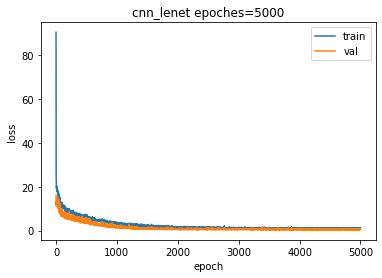

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn_lenet epoches=5000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [27]:
#``mlp4`` from the tf_models module
model_mlp4= mlp4(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_mlp4.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_mlp4.fit(train_dataset, epochs=500, validation_data=val_dataset)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 flatten_6 (Flatten)         (None, 4800)              0         
                                                                 
 dropout_12 (Dropout)        (None, 4800)              0         
                                                                 
 dense_18 (Dense)            (None, 500)               2400500   
                                                                 
 dropout_13 (Dropout)        (None, 500)               0         
                                                                 
 dense_19 (Dense)            (None, 500)               250500    
                                                                 
 dropout_14 (Dropout)        (None, 500)               0   

Epoch 40/500
11/11 [==============================] - 0s 23ms/step - loss: 10.5096 - mean_squared_error: 10.5096 - val_loss: 8.4340 - val_mean_squared_error: 8.4340
Epoch 41/500
11/11 [==============================] - 0s 22ms/step - loss: 10.7059 - mean_squared_error: 10.7059 - val_loss: 8.8998 - val_mean_squared_error: 8.8998
Epoch 42/500
11/11 [==============================] - 0s 22ms/step - loss: 9.8769 - mean_squared_error: 9.8769 - val_loss: 12.0609 - val_mean_squared_error: 12.0609
Epoch 43/500
11/11 [==============================] - 0s 22ms/step - loss: 9.3827 - mean_squared_error: 9.3827 - val_loss: 7.3362 - val_mean_squared_error: 7.3362
Epoch 44/500
11/11 [==============================] - 0s 22ms/step - loss: 9.3827 - mean_squared_error: 9.3827 - val_loss: 8.7613 - val_mean_squared_error: 8.7613
Epoch 45/500
11/11 [==============================] - 0s 22ms/step - loss: 10.6061 - mean_squared_error: 10.6061 - val_loss: 9.1713 - val_mean_squared_error: 9.1713
Epoch 46/500
1

Epoch 90/500
11/11 [==============================] - 0s 26ms/step - loss: 10.7714 - mean_squared_error: 10.7714 - val_loss: 13.9619 - val_mean_squared_error: 13.9619
Epoch 91/500
11/11 [==============================] - 0s 24ms/step - loss: 9.0204 - mean_squared_error: 9.0204 - val_loss: 6.8894 - val_mean_squared_error: 6.8894
Epoch 92/500
11/11 [==============================] - 0s 22ms/step - loss: 9.1769 - mean_squared_error: 9.1769 - val_loss: 7.0102 - val_mean_squared_error: 7.0102
Epoch 93/500
11/11 [==============================] - 0s 22ms/step - loss: 9.3237 - mean_squared_error: 9.3237 - val_loss: 8.6690 - val_mean_squared_error: 8.6690
Epoch 94/500
11/11 [==============================] - 0s 22ms/step - loss: 8.2674 - mean_squared_error: 8.2674 - val_loss: 6.2778 - val_mean_squared_error: 6.2778
Epoch 95/500
11/11 [==============================] - 0s 22ms/step - loss: 8.4875 - mean_squared_error: 8.4875 - val_loss: 11.9221 - val_mean_squared_error: 11.9221
Epoch 96/500
11/

11/11 [==============================] - 0s 24ms/step - loss: 8.9822 - mean_squared_error: 8.9822 - val_loss: 10.3916 - val_mean_squared_error: 10.3916
Epoch 140/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9571 - mean_squared_error: 8.9571 - val_loss: 8.6955 - val_mean_squared_error: 8.6955
Epoch 141/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9296 - mean_squared_error: 8.9296 - val_loss: 21.5179 - val_mean_squared_error: 21.5179
Epoch 142/500
11/11 [==============================] - 0s 22ms/step - loss: 10.9078 - mean_squared_error: 10.9078 - val_loss: 10.0006 - val_mean_squared_error: 10.0006
Epoch 143/500
11/11 [==============================] - 0s 22ms/step - loss: 10.6771 - mean_squared_error: 10.6771 - val_loss: 8.2653 - val_mean_squared_error: 8.2653
Epoch 144/500
11/11 [==============================] - 0s 23ms/step - loss: 10.0830 - mean_squared_error: 10.0830 - val_loss: 13.8865 - val_mean_squared_error: 13.8865
Epoch 145/500
11

Epoch 189/500
11/11 [==============================] - 0s 22ms/step - loss: 9.1814 - mean_squared_error: 9.1814 - val_loss: 8.4864 - val_mean_squared_error: 8.4864
Epoch 190/500
11/11 [==============================] - 0s 25ms/step - loss: 8.7110 - mean_squared_error: 8.7110 - val_loss: 9.0499 - val_mean_squared_error: 9.0499
Epoch 191/500
11/11 [==============================] - 0s 22ms/step - loss: 8.5824 - mean_squared_error: 8.5824 - val_loss: 7.5963 - val_mean_squared_error: 7.5963
Epoch 192/500
11/11 [==============================] - 0s 22ms/step - loss: 7.9271 - mean_squared_error: 7.9271 - val_loss: 8.9119 - val_mean_squared_error: 8.9119
Epoch 193/500
11/11 [==============================] - 0s 22ms/step - loss: 9.1117 - mean_squared_error: 9.1117 - val_loss: 7.7614 - val_mean_squared_error: 7.7614
Epoch 194/500
11/11 [==============================] - 0s 23ms/step - loss: 8.7364 - mean_squared_error: 8.7364 - val_loss: 8.4134 - val_mean_squared_error: 8.4134
Epoch 195/500
11

Epoch 239/500
11/11 [==============================] - 0s 24ms/step - loss: 8.9802 - mean_squared_error: 8.9802 - val_loss: 10.9155 - val_mean_squared_error: 10.9155
Epoch 240/500
11/11 [==============================] - 0s 32ms/step - loss: 9.0965 - mean_squared_error: 9.0965 - val_loss: 9.3438 - val_mean_squared_error: 9.3438
Epoch 241/500
11/11 [==============================] - 0s 24ms/step - loss: 8.7545 - mean_squared_error: 8.7545 - val_loss: 10.9864 - val_mean_squared_error: 10.9864
Epoch 242/500
11/11 [==============================] - 0s 22ms/step - loss: 9.0060 - mean_squared_error: 9.0060 - val_loss: 7.2743 - val_mean_squared_error: 7.2743
Epoch 243/500
11/11 [==============================] - 0s 23ms/step - loss: 8.3957 - mean_squared_error: 8.3957 - val_loss: 9.9851 - val_mean_squared_error: 9.9851
Epoch 244/500
11/11 [==============================] - 0s 22ms/step - loss: 8.7678 - mean_squared_error: 8.7678 - val_loss: 7.9169 - val_mean_squared_error: 7.9169
Epoch 245/50

Epoch 289/500
11/11 [==============================] - 0s 24ms/step - loss: 8.4279 - mean_squared_error: 8.4279 - val_loss: 9.2622 - val_mean_squared_error: 9.2622
Epoch 290/500
11/11 [==============================] - 0s 22ms/step - loss: 9.0814 - mean_squared_error: 9.0814 - val_loss: 6.3285 - val_mean_squared_error: 6.3285
Epoch 291/500
11/11 [==============================] - 0s 23ms/step - loss: 8.4183 - mean_squared_error: 8.4183 - val_loss: 8.9485 - val_mean_squared_error: 8.9485
Epoch 292/500
11/11 [==============================] - 0s 23ms/step - loss: 8.3327 - mean_squared_error: 8.3327 - val_loss: 8.0101 - val_mean_squared_error: 8.0101
Epoch 293/500
11/11 [==============================] - 0s 23ms/step - loss: 8.5518 - mean_squared_error: 8.5518 - val_loss: 10.1074 - val_mean_squared_error: 10.1074
Epoch 294/500
11/11 [==============================] - 0s 22ms/step - loss: 8.2978 - mean_squared_error: 8.2978 - val_loss: 7.4267 - val_mean_squared_error: 7.4267
Epoch 295/500


Epoch 339/500
11/11 [==============================] - 0s 22ms/step - loss: 8.8431 - mean_squared_error: 8.8431 - val_loss: 11.8037 - val_mean_squared_error: 11.8037
Epoch 340/500
11/11 [==============================] - 0s 23ms/step - loss: 8.8160 - mean_squared_error: 8.8160 - val_loss: 7.7624 - val_mean_squared_error: 7.7624
Epoch 341/500
11/11 [==============================] - 0s 22ms/step - loss: 8.3926 - mean_squared_error: 8.3926 - val_loss: 8.9067 - val_mean_squared_error: 8.9067
Epoch 342/500
11/11 [==============================] - 0s 22ms/step - loss: 8.3832 - mean_squared_error: 8.3832 - val_loss: 8.0988 - val_mean_squared_error: 8.0988
Epoch 343/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9014 - mean_squared_error: 8.9014 - val_loss: 10.5975 - val_mean_squared_error: 10.5975
Epoch 344/500
11/11 [==============================] - 0s 23ms/step - loss: 8.8535 - mean_squared_error: 8.8535 - val_loss: 6.0997 - val_mean_squared_error: 6.0997
Epoch 345/50

Epoch 389/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9375 - mean_squared_error: 8.9375 - val_loss: 6.5394 - val_mean_squared_error: 6.5394
Epoch 390/500
11/11 [==============================] - 0s 22ms/step - loss: 9.4648 - mean_squared_error: 9.4648 - val_loss: 9.3177 - val_mean_squared_error: 9.3177
Epoch 391/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9035 - mean_squared_error: 8.9035 - val_loss: 6.5573 - val_mean_squared_error: 6.5573
Epoch 392/500
11/11 [==============================] - 0s 22ms/step - loss: 8.6912 - mean_squared_error: 8.6912 - val_loss: 14.1386 - val_mean_squared_error: 14.1386
Epoch 393/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9918 - mean_squared_error: 8.9918 - val_loss: 7.7341 - val_mean_squared_error: 7.7341
Epoch 394/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9728 - mean_squared_error: 8.9728 - val_loss: 9.4069 - val_mean_squared_error: 9.4069
Epoch 395/500


Epoch 439/500
11/11 [==============================] - 0s 24ms/step - loss: 8.9186 - mean_squared_error: 8.9186 - val_loss: 8.0250 - val_mean_squared_error: 8.0250
Epoch 440/500
11/11 [==============================] - 0s 22ms/step - loss: 9.0124 - mean_squared_error: 9.0124 - val_loss: 8.3950 - val_mean_squared_error: 8.3950
Epoch 441/500
11/11 [==============================] - 0s 22ms/step - loss: 8.5773 - mean_squared_error: 8.5773 - val_loss: 11.9390 - val_mean_squared_error: 11.9390
Epoch 442/500
11/11 [==============================] - 0s 22ms/step - loss: 8.7898 - mean_squared_error: 8.7898 - val_loss: 6.1775 - val_mean_squared_error: 6.1775
Epoch 443/500
11/11 [==============================] - 0s 22ms/step - loss: 10.3827 - mean_squared_error: 10.3827 - val_loss: 13.8369 - val_mean_squared_error: 13.8369
Epoch 444/500
11/11 [==============================] - 0s 22ms/step - loss: 9.9150 - mean_squared_error: 9.9150 - val_loss: 17.7005 - val_mean_squared_error: 17.7005
Epoch 44

Epoch 489/500
11/11 [==============================] - 0s 22ms/step - loss: 8.5641 - mean_squared_error: 8.5641 - val_loss: 13.4018 - val_mean_squared_error: 13.4018
Epoch 490/500
11/11 [==============================] - 0s 22ms/step - loss: 8.3387 - mean_squared_error: 8.3387 - val_loss: 9.6933 - val_mean_squared_error: 9.6933
Epoch 491/500
11/11 [==============================] - 0s 23ms/step - loss: 8.8163 - mean_squared_error: 8.8163 - val_loss: 8.3142 - val_mean_squared_error: 8.3142
Epoch 492/500
11/11 [==============================] - 0s 23ms/step - loss: 8.3640 - mean_squared_error: 8.3640 - val_loss: 9.5865 - val_mean_squared_error: 9.5865
Epoch 493/500
11/11 [==============================] - 0s 23ms/step - loss: 8.2523 - mean_squared_error: 8.2523 - val_loss: 6.3636 - val_mean_squared_error: 6.3636
Epoch 494/500
11/11 [==============================] - 0s 23ms/step - loss: 8.7967 - mean_squared_error: 8.7967 - val_loss: 12.2675 - val_mean_squared_error: 12.2675
Epoch 495/50

In [36]:
# Evaluate the model on the validation set
eval_mlp4 = model_mlp4.evaluate(val_dataset)
# update the result
results.update({'mlp4': eval_mlp4})

3/3 [==============================] - 0s 16ms/step - loss: 10.9798 - mean_squared_error: 10.9798


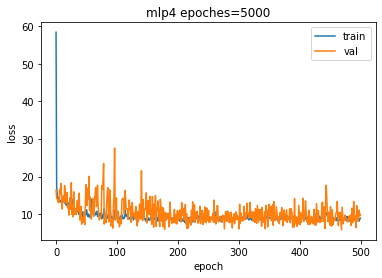

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mlp4 epoches=5000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [58]:
#``cnn_vgg`` from the tf_models module
model_cnn_vgg= cnn_vgg(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_cnn_vgg.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_cnn_vgg.fit(train_dataset, epochs=100, validation_data=val_dataset)

pooling layers: 4
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_54 (Conv1D)          (None, 100, 64)           9280      
                                                                 
 conv1d_55 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_56 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_57 (Conv1D)          (None, 50, 128)           49280     
                                        

11/11 [==============================] - 5s 481ms/step - loss: 6.5538 - mean_squared_error: 6.5538 - val_loss: 7.0594 - val_mean_squared_error: 7.0594
Epoch 30/100
11/11 [==============================] - 5s 477ms/step - loss: 6.2584 - mean_squared_error: 6.2584 - val_loss: 5.1776 - val_mean_squared_error: 5.1776
Epoch 31/100
11/11 [==============================] - 5s 475ms/step - loss: 6.4108 - mean_squared_error: 6.4108 - val_loss: 9.4026 - val_mean_squared_error: 9.4026
Epoch 32/100
11/11 [==============================] - 5s 502ms/step - loss: 7.0744 - mean_squared_error: 7.0744 - val_loss: 4.7303 - val_mean_squared_error: 4.7303
Epoch 33/100
11/11 [==============================] - 6s 529ms/step - loss: 6.1116 - mean_squared_error: 6.1116 - val_loss: 7.0959 - val_mean_squared_error: 7.0959
Epoch 34/100
11/11 [==============================] - 5s 484ms/step - loss: 5.5229 - mean_squared_error: 5.5229 - val_loss: 4.6175 - val_mean_squared_error: 4.6175
Epoch 35/100
11/11 [=========

11/11 [==============================] - 5s 471ms/step - loss: 1.6793 - mean_squared_error: 1.6793 - val_loss: 2.1284 - val_mean_squared_error: 2.1284
Epoch 80/100
11/11 [==============================] - 5s 473ms/step - loss: 1.9034 - mean_squared_error: 1.9034 - val_loss: 1.9969 - val_mean_squared_error: 1.9969
Epoch 81/100
11/11 [==============================] - 5s 487ms/step - loss: 1.9229 - mean_squared_error: 1.9229 - val_loss: 2.4363 - val_mean_squared_error: 2.4363
Epoch 82/100
11/11 [==============================] - 5s 473ms/step - loss: 1.8199 - mean_squared_error: 1.8199 - val_loss: 0.8866 - val_mean_squared_error: 0.8866
Epoch 83/100
11/11 [==============================] - 5s 477ms/step - loss: 1.7368 - mean_squared_error: 1.7368 - val_loss: 0.9249 - val_mean_squared_error: 0.9249
Epoch 84/100
11/11 [==============================] - 5s 474ms/step - loss: 1.3960 - mean_squared_error: 1.3960 - val_loss: 0.9574 - val_mean_squared_error: 0.9574
Epoch 85/100
11/11 [=========

In [59]:
# Evaluate the model on the validation set
eval_cnn_vgg = model_cnn_vgg.evaluate(val_dataset)
# update the result
results.update({'cnn_vgg': eval_cnn_vgg})

3/3 [==============================] - 0s 97ms/step - loss: 0.7786 - mean_squared_error: 0.7786


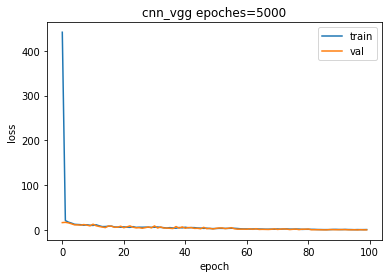

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn_vgg epoches=5000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [33]:
#``lstm1v0`` from the tf_models module
model_lstm1v0= lstm1v0(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile themodel and fit it using training data
model_lstm1v0.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_lstm1v0.fit(train_dataset, epochs=500, validation_data=val_dataset)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               59600     
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 141ms/step - loss: 102.7609 - mean_squared_error: 102.7609 - val_loss: 53.0524 - val_mean_squared_error: 53.0524
Epoch 2/500
11/11 [==============================] - 1s 109ms/step - loss: 34.5665 - mean_squared_error: 34.5665 - val_loss: 15.0417 - val_mean_squar

Epoch 45/500
11/11 [==============================] - 1s 120ms/step - loss: 12.7932 - mean_squared_error: 12.7932 - val_loss: 13.6338 - val_mean_squared_error: 13.6338
Epoch 46/500
11/11 [==============================] - 1s 132ms/step - loss: 12.7658 - mean_squared_error: 12.7658 - val_loss: 12.5747 - val_mean_squared_error: 12.5747
Epoch 47/500
11/11 [==============================] - 1s 109ms/step - loss: 12.5151 - mean_squared_error: 12.5151 - val_loss: 13.9689 - val_mean_squared_error: 13.9689
Epoch 48/500
11/11 [==============================] - 1s 128ms/step - loss: 12.8600 - mean_squared_error: 12.8600 - val_loss: 11.9371 - val_mean_squared_error: 11.9371
Epoch 49/500
11/11 [==============================] - 2s 178ms/step - loss: 12.8335 - mean_squared_error: 12.8335 - val_loss: 13.1984 - val_mean_squared_error: 13.1984
Epoch 50/500
11/11 [==============================] - 1s 133ms/step - loss: 12.5789 - mean_squared_error: 12.5789 - val_loss: 14.4478 - val_mean_squared_error: 

Epoch 94/500
11/11 [==============================] - 1s 115ms/step - loss: 12.6454 - mean_squared_error: 12.6454 - val_loss: 12.3139 - val_mean_squared_error: 12.3139
Epoch 95/500
11/11 [==============================] - 1s 109ms/step - loss: 12.4528 - mean_squared_error: 12.4528 - val_loss: 12.4984 - val_mean_squared_error: 12.4984
Epoch 96/500
11/11 [==============================] - 1s 109ms/step - loss: 12.5193 - mean_squared_error: 12.5193 - val_loss: 11.7935 - val_mean_squared_error: 11.7935
Epoch 97/500
11/11 [==============================] - 1s 108ms/step - loss: 12.7577 - mean_squared_error: 12.7577 - val_loss: 12.7296 - val_mean_squared_error: 12.7296
Epoch 98/500
11/11 [==============================] - 1s 108ms/step - loss: 12.8680 - mean_squared_error: 12.8680 - val_loss: 12.9526 - val_mean_squared_error: 12.9526
Epoch 99/500
11/11 [==============================] - 1s 108ms/step - loss: 12.4038 - mean_squared_error: 12.4038 - val_loss: 13.0361 - val_mean_squared_error: 

11/11 [==============================] - 1s 115ms/step - loss: 12.6682 - mean_squared_error: 12.6682 - val_loss: 11.7609 - val_mean_squared_error: 11.7609
Epoch 143/500
11/11 [==============================] - 1s 109ms/step - loss: 12.8949 - mean_squared_error: 12.8949 - val_loss: 13.9595 - val_mean_squared_error: 13.9595
Epoch 144/500
11/11 [==============================] - 1s 109ms/step - loss: 11.9640 - mean_squared_error: 11.9640 - val_loss: 11.4567 - val_mean_squared_error: 11.4567
Epoch 145/500
11/11 [==============================] - 1s 107ms/step - loss: 12.6432 - mean_squared_error: 12.6432 - val_loss: 10.8868 - val_mean_squared_error: 10.8868
Epoch 146/500
11/11 [==============================] - 1s 108ms/step - loss: 12.1973 - mean_squared_error: 12.1973 - val_loss: 11.7537 - val_mean_squared_error: 11.7537
Epoch 147/500
11/11 [==============================] - 1s 109ms/step - loss: 12.5887 - mean_squared_error: 12.5887 - val_loss: 11.7591 - val_mean_squared_error: 11.7591


11/11 [==============================] - 1s 119ms/step - loss: 12.2124 - mean_squared_error: 12.2124 - val_loss: 11.4346 - val_mean_squared_error: 11.4346
Epoch 191/500
11/11 [==============================] - 1s 108ms/step - loss: 12.3306 - mean_squared_error: 12.3306 - val_loss: 11.8636 - val_mean_squared_error: 11.8636
Epoch 192/500
11/11 [==============================] - 1s 109ms/step - loss: 12.8665 - mean_squared_error: 12.8665 - val_loss: 14.0531 - val_mean_squared_error: 14.0531
Epoch 193/500
11/11 [==============================] - 1s 107ms/step - loss: 12.5499 - mean_squared_error: 12.5499 - val_loss: 11.9987 - val_mean_squared_error: 11.9987
Epoch 194/500
11/11 [==============================] - 1s 108ms/step - loss: 12.8111 - mean_squared_error: 12.8111 - val_loss: 12.3360 - val_mean_squared_error: 12.3360
Epoch 195/500
11/11 [==============================] - 1s 108ms/step - loss: 12.7451 - mean_squared_error: 12.7451 - val_loss: 11.9889 - val_mean_squared_error: 11.9889


11/11 [==============================] - 1s 118ms/step - loss: 12.3724 - mean_squared_error: 12.3724 - val_loss: 13.2414 - val_mean_squared_error: 13.2414
Epoch 239/500
11/11 [==============================] - 1s 108ms/step - loss: 12.9384 - mean_squared_error: 12.9384 - val_loss: 13.1216 - val_mean_squared_error: 13.1216
Epoch 240/500
11/11 [==============================] - 1s 110ms/step - loss: 12.5885 - mean_squared_error: 12.5885 - val_loss: 10.9589 - val_mean_squared_error: 10.9589
Epoch 241/500
11/11 [==============================] - 1s 109ms/step - loss: 12.4389 - mean_squared_error: 12.4389 - val_loss: 12.7708 - val_mean_squared_error: 12.7708
Epoch 242/500
11/11 [==============================] - 1s 108ms/step - loss: 12.8864 - mean_squared_error: 12.8864 - val_loss: 14.6896 - val_mean_squared_error: 14.6896
Epoch 243/500
11/11 [==============================] - 1s 109ms/step - loss: 12.6377 - mean_squared_error: 12.6377 - val_loss: 10.5904 - val_mean_squared_error: 10.5904


11/11 [==============================] - 1s 123ms/step - loss: 13.4622 - mean_squared_error: 13.4622 - val_loss: 12.0955 - val_mean_squared_error: 12.0955
Epoch 287/500
11/11 [==============================] - 1s 109ms/step - loss: 12.8668 - mean_squared_error: 12.8668 - val_loss: 13.1517 - val_mean_squared_error: 13.1517
Epoch 288/500
11/11 [==============================] - 1s 109ms/step - loss: 12.7492 - mean_squared_error: 12.7492 - val_loss: 14.2199 - val_mean_squared_error: 14.2199
Epoch 289/500
11/11 [==============================] - 1s 109ms/step - loss: 12.7989 - mean_squared_error: 12.7989 - val_loss: 12.0287 - val_mean_squared_error: 12.0287
Epoch 290/500
11/11 [==============================] - 1s 110ms/step - loss: 12.7139 - mean_squared_error: 12.7139 - val_loss: 12.8006 - val_mean_squared_error: 12.8006
Epoch 291/500
11/11 [==============================] - 1s 108ms/step - loss: 12.8139 - mean_squared_error: 12.8139 - val_loss: 13.7401 - val_mean_squared_error: 13.7401


11/11 [==============================] - 1s 110ms/step - loss: 12.5509 - mean_squared_error: 12.5509 - val_loss: 13.5975 - val_mean_squared_error: 13.5975
Epoch 335/500
11/11 [==============================] - 1s 108ms/step - loss: 12.9475 - mean_squared_error: 12.9475 - val_loss: 14.3800 - val_mean_squared_error: 14.3800
Epoch 336/500
11/11 [==============================] - 1s 111ms/step - loss: 12.6173 - mean_squared_error: 12.6173 - val_loss: 12.3182 - val_mean_squared_error: 12.3182
Epoch 337/500
11/11 [==============================] - 1s 109ms/step - loss: 12.4460 - mean_squared_error: 12.4460 - val_loss: 13.5261 - val_mean_squared_error: 13.5261
Epoch 338/500
11/11 [==============================] - 1s 108ms/step - loss: 12.5225 - mean_squared_error: 12.5225 - val_loss: 13.3988 - val_mean_squared_error: 13.3988
Epoch 339/500
11/11 [==============================] - 1s 108ms/step - loss: 12.7707 - mean_squared_error: 12.7707 - val_loss: 11.5839 - val_mean_squared_error: 11.5839


11/11 [==============================] - 1s 108ms/step - loss: 11.5023 - mean_squared_error: 11.5023 - val_loss: 12.2050 - val_mean_squared_error: 12.2050
Epoch 383/500
11/11 [==============================] - 1s 109ms/step - loss: 12.5356 - mean_squared_error: 12.5356 - val_loss: 13.0360 - val_mean_squared_error: 13.0360
Epoch 384/500
11/11 [==============================] - 1s 110ms/step - loss: 11.6521 - mean_squared_error: 11.6521 - val_loss: 12.1291 - val_mean_squared_error: 12.1291
Epoch 385/500
11/11 [==============================] - 1s 109ms/step - loss: 11.5806 - mean_squared_error: 11.5806 - val_loss: 13.2909 - val_mean_squared_error: 13.2909
Epoch 386/500
11/11 [==============================] - 1s 110ms/step - loss: 11.3731 - mean_squared_error: 11.3731 - val_loss: 11.5332 - val_mean_squared_error: 11.5332
Epoch 387/500
11/11 [==============================] - 1s 108ms/step - loss: 12.3021 - mean_squared_error: 12.3021 - val_loss: 11.9193 - val_mean_squared_error: 11.9193


Epoch 431/500
11/11 [==============================] - 1s 109ms/step - loss: 9.7337 - mean_squared_error: 9.7337 - val_loss: 9.8834 - val_mean_squared_error: 9.8834
Epoch 432/500
11/11 [==============================] - 1s 109ms/step - loss: 9.1561 - mean_squared_error: 9.1561 - val_loss: 9.1618 - val_mean_squared_error: 9.1618
Epoch 433/500
11/11 [==============================] - 1s 108ms/step - loss: 8.3889 - mean_squared_error: 8.3889 - val_loss: 9.2769 - val_mean_squared_error: 9.2769
Epoch 434/500
11/11 [==============================] - 1s 109ms/step - loss: 8.0540 - mean_squared_error: 8.0540 - val_loss: 9.0731 - val_mean_squared_error: 9.0731
Epoch 435/500
11/11 [==============================] - 1s 108ms/step - loss: 8.8500 - mean_squared_error: 8.8500 - val_loss: 8.2728 - val_mean_squared_error: 8.2728
Epoch 436/500
11/11 [==============================] - 1s 113ms/step - loss: 8.2050 - mean_squared_error: 8.2050 - val_loss: 8.5880 - val_mean_squared_error: 8.5880
Epoch 437/

Epoch 481/500
11/11 [==============================] - 1s 108ms/step - loss: 6.7575 - mean_squared_error: 6.7575 - val_loss: 6.6951 - val_mean_squared_error: 6.6951
Epoch 482/500
11/11 [==============================] - 1s 108ms/step - loss: 6.9858 - mean_squared_error: 6.9858 - val_loss: 6.6102 - val_mean_squared_error: 6.6102
Epoch 483/500
11/11 [==============================] - 1s 111ms/step - loss: 7.2880 - mean_squared_error: 7.2880 - val_loss: 5.5740 - val_mean_squared_error: 5.5740
Epoch 484/500
11/11 [==============================] - 1s 112ms/step - loss: 6.8444 - mean_squared_error: 6.8444 - val_loss: 6.6817 - val_mean_squared_error: 6.6817
Epoch 485/500
11/11 [==============================] - 1s 109ms/step - loss: 6.7114 - mean_squared_error: 6.7114 - val_loss: 7.8427 - val_mean_squared_error: 7.8427
Epoch 486/500
11/11 [==============================] - 1s 108ms/step - loss: 6.7147 - mean_squared_error: 6.7147 - val_loss: 6.7075 - val_mean_squared_error: 6.7075
Epoch 487/

In [38]:
# Evaluate the model on the validation set
eval_lstm1v0 = model_lstm1v0.evaluate(val_dataset)
# update the result
results.update({'lstm1v0': eval_lstm1v0})

3/3 [==============================] - 0s 29ms/step - loss: 6.4764 - mean_squared_error: 6.4764


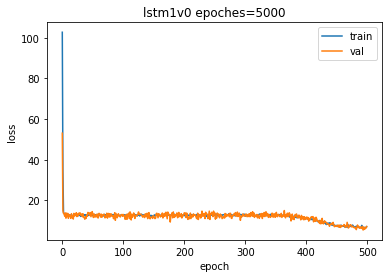

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm1v0 epoches=5000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [51]:
#``lstm1`` from the tf_models module
model_lstm1= lstm1(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm1.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_lstm1.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm1 = model_lstm1.evaluate(val_dataset)
# update the result
results.update({'lstm1': eval_lstm1})

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               59600     
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 3s 150ms/step - loss: 98.7984 - mean_squared_error: 98.7984 - val_loss: 47.9539 - val_mean_squared_error: 47.9539
Epoch 2/100
11/11 [==============================] - 1s 120ms/step - loss: 28.9308 - mean_squared_error: 28.9308 - val_loss: 17.8853 - val_mean_squared

Epoch 45/100
11/11 [==============================] - 1s 110ms/step - loss: 12.7954 - mean_squared_error: 12.7954 - val_loss: 12.0830 - val_mean_squared_error: 12.0830
Epoch 46/100
11/11 [==============================] - 1s 110ms/step - loss: 12.6565 - mean_squared_error: 12.6565 - val_loss: 13.6807 - val_mean_squared_error: 13.6807
Epoch 47/100
11/11 [==============================] - 1s 110ms/step - loss: 12.6624 - mean_squared_error: 12.6624 - val_loss: 12.9925 - val_mean_squared_error: 12.9925
Epoch 48/100
11/11 [==============================] - 1s 109ms/step - loss: 13.5035 - mean_squared_error: 13.5035 - val_loss: 12.5104 - val_mean_squared_error: 12.5104
Epoch 49/100
11/11 [==============================] - 1s 111ms/step - loss: 12.2773 - mean_squared_error: 12.2773 - val_loss: 11.1278 - val_mean_squared_error: 11.1278
Epoch 50/100
11/11 [==============================] - 1s 110ms/step - loss: 12.5880 - mean_squared_error: 12.5880 - val_loss: 14.4573 - val_mean_squared_error: 

Epoch 94/100
11/11 [==============================] - 1s 120ms/step - loss: 12.6770 - mean_squared_error: 12.6770 - val_loss: 12.9918 - val_mean_squared_error: 12.9918
Epoch 95/100
11/11 [==============================] - 1s 117ms/step - loss: 12.7917 - mean_squared_error: 12.7917 - val_loss: 13.7872 - val_mean_squared_error: 13.7872
Epoch 96/100
11/11 [==============================] - 1s 117ms/step - loss: 13.1538 - mean_squared_error: 13.1538 - val_loss: 12.6755 - val_mean_squared_error: 12.6755
Epoch 97/100
11/11 [==============================] - 1s 122ms/step - loss: 12.8723 - mean_squared_error: 12.8723 - val_loss: 12.3312 - val_mean_squared_error: 12.3312
Epoch 98/100
11/11 [==============================] - 1s 121ms/step - loss: 12.5745 - mean_squared_error: 12.5745 - val_loss: 12.3962 - val_mean_squared_error: 12.3962
Epoch 99/100
11/11 [==============================] - 1s 120ms/step - loss: 13.0475 - mean_squared_error: 13.0475 - val_loss: 13.0033 - val_mean_squared_error: 

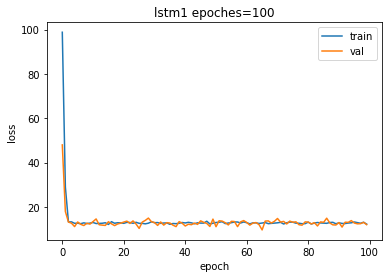

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm1 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [53]:
#``lstm2`` from the tf_models module
model_lstm2= lstm2(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm2.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_lstm2.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm2 = model_lstm2.evaluate(val_dataset)
# update the result
results.update({'lstm2': eval_lstm2})

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 100)          59600     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 140,101
Trainable params: 140,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 6s 297ms/step - loss: 81.1756 - mean_squared_error: 81.1756 - val_loss: 21.8543 - val_mean_squared_error: 21.8543
Epoch 2/100
11/11

11/11 [==============================] - 3s 238ms/step - loss: 12.4454 - mean_squared_error: 12.4454 - val_loss: 10.8894 - val_mean_squared_error: 10.8894
Epoch 45/100
11/11 [==============================] - 2s 222ms/step - loss: 12.9918 - mean_squared_error: 12.9918 - val_loss: 11.9702 - val_mean_squared_error: 11.9702
Epoch 46/100
11/11 [==============================] - 3s 243ms/step - loss: 12.7463 - mean_squared_error: 12.7463 - val_loss: 14.8637 - val_mean_squared_error: 14.8637
Epoch 47/100
11/11 [==============================] - 3s 265ms/step - loss: 12.8073 - mean_squared_error: 12.8073 - val_loss: 12.7735 - val_mean_squared_error: 12.7735
Epoch 48/100
11/11 [==============================] - 3s 273ms/step - loss: 12.9602 - mean_squared_error: 12.9602 - val_loss: 12.2452 - val_mean_squared_error: 12.2452
Epoch 49/100
11/11 [==============================] - 3s 261ms/step - loss: 12.9703 - mean_squared_error: 12.9703 - val_loss: 11.9879 - val_mean_squared_error: 11.9879
Epoch

Epoch 93/100
11/11 [==============================] - 3s 234ms/step - loss: 12.6825 - mean_squared_error: 12.6825 - val_loss: 12.9027 - val_mean_squared_error: 12.9027
Epoch 94/100
11/11 [==============================] - 3s 232ms/step - loss: 12.7125 - mean_squared_error: 12.7125 - val_loss: 13.4282 - val_mean_squared_error: 13.4282
Epoch 95/100
11/11 [==============================] - 3s 232ms/step - loss: 12.4079 - mean_squared_error: 12.4079 - val_loss: 12.8691 - val_mean_squared_error: 12.8691
Epoch 96/100
11/11 [==============================] - 3s 231ms/step - loss: 12.1852 - mean_squared_error: 12.1852 - val_loss: 12.0114 - val_mean_squared_error: 12.0114
Epoch 97/100
11/11 [==============================] - 3s 230ms/step - loss: 12.4746 - mean_squared_error: 12.4746 - val_loss: 12.3874 - val_mean_squared_error: 12.3874
Epoch 98/100
11/11 [==============================] - 3s 231ms/step - loss: 12.7008 - mean_squared_error: 12.7008 - val_loss: 13.1632 - val_mean_squared_error: 

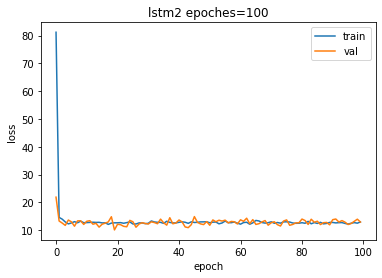

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm2 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [55]:
#``blstm1`` from the tf_models module
model_blstm1= blstm1(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_blstm1.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_blstm1.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_blstm1 = model_blstm1.evaluate(val_dataset)
# update the result
results.update({'blstm1': eval_blstm1})

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              119200    
 l)                                                              
                                                                 
 dense_34 (Dense)            (None, 1)                 201       
                                                                 
Total params: 119,401
Trainable params: 119,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 5s 248ms/step - loss: 78.2261 - mean_squared_error: 78.2261 - val_loss: 24.3760 - val_mean_squared_error: 24.3760
Epoch 2/100
11/11 [==============================] - 2s 181ms/step - loss: 16.5562 

11/11 [==============================] - 2s 186ms/step - loss: 12.7603 - mean_squared_error: 12.7603 - val_loss: 14.6260 - val_mean_squared_error: 14.6260
Epoch 45/100
11/11 [==============================] - 2s 189ms/step - loss: 13.0063 - mean_squared_error: 13.0063 - val_loss: 13.1259 - val_mean_squared_error: 13.1259
Epoch 46/100
11/11 [==============================] - 2s 172ms/step - loss: 12.6589 - mean_squared_error: 12.6589 - val_loss: 11.0918 - val_mean_squared_error: 11.0918
Epoch 47/100
11/11 [==============================] - 2s 169ms/step - loss: 12.5870 - mean_squared_error: 12.5870 - val_loss: 14.5496 - val_mean_squared_error: 14.5496
Epoch 48/100
11/11 [==============================] - 2s 164ms/step - loss: 12.3751 - mean_squared_error: 12.3751 - val_loss: 14.1963 - val_mean_squared_error: 14.1963
Epoch 49/100
11/11 [==============================] - 2s 180ms/step - loss: 12.8280 - mean_squared_error: 12.8280 - val_loss: 9.5698 - val_mean_squared_error: 9.5698
Epoch 5

Epoch 93/100
11/11 [==============================] - 2s 185ms/step - loss: 12.2642 - mean_squared_error: 12.2642 - val_loss: 12.7391 - val_mean_squared_error: 12.7391
Epoch 94/100
11/11 [==============================] - 2s 192ms/step - loss: 13.0452 - mean_squared_error: 13.0452 - val_loss: 12.5524 - val_mean_squared_error: 12.5524
Epoch 95/100
11/11 [==============================] - 2s 174ms/step - loss: 12.8895 - mean_squared_error: 12.8895 - val_loss: 13.1975 - val_mean_squared_error: 13.1975
Epoch 96/100
11/11 [==============================] - 2s 174ms/step - loss: 13.0615 - mean_squared_error: 13.0615 - val_loss: 12.2372 - val_mean_squared_error: 12.2372
Epoch 97/100
11/11 [==============================] - 2s 168ms/step - loss: 12.7700 - mean_squared_error: 12.7700 - val_loss: 13.8083 - val_mean_squared_error: 13.8083
Epoch 98/100
11/11 [==============================] - 2s 181ms/step - loss: 12.6981 - mean_squared_error: 12.6981 - val_loss: 11.0075 - val_mean_squared_error: 

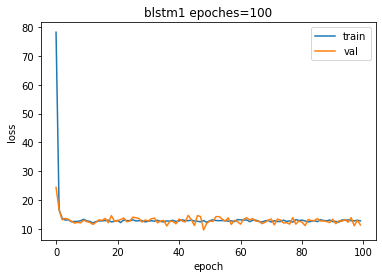

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('blstm1 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [61]:
#``blstm2`` from the tf_models module
model_blstm2= blstm2(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_blstm2.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_blstm2.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_blstm2 = model_blstm2.evaluate(val_dataset)
# update the result
results.update({'blstm2': eval_blstm2})

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 200)         119200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_41 (Dense)            (None, 1)                 201       
                                                                 
Total params: 360,201
Trainable params: 360,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] -

11/11 [==============================] - 5s 426ms/step - loss: 12.8637 - mean_squared_error: 12.8637 - val_loss: 11.9011 - val_mean_squared_error: 11.9011
Epoch 44/100
11/11 [==============================] - 5s 421ms/step - loss: 12.5015 - mean_squared_error: 12.5015 - val_loss: 12.4446 - val_mean_squared_error: 12.4446
Epoch 45/100
11/11 [==============================] - 5s 421ms/step - loss: 12.2435 - mean_squared_error: 12.2435 - val_loss: 12.4445 - val_mean_squared_error: 12.4445
Epoch 46/100
11/11 [==============================] - 5s 423ms/step - loss: 12.6567 - mean_squared_error: 12.6567 - val_loss: 14.0320 - val_mean_squared_error: 14.0320
Epoch 47/100
11/11 [==============================] - 5s 421ms/step - loss: 12.2954 - mean_squared_error: 12.2954 - val_loss: 11.8620 - val_mean_squared_error: 11.8620
Epoch 48/100
11/11 [==============================] - 5s 425ms/step - loss: 13.2248 - mean_squared_error: 13.2248 - val_loss: 11.9586 - val_mean_squared_error: 11.9586
Epoch

Epoch 92/100
11/11 [==============================] - 6s 504ms/step - loss: 12.3139 - mean_squared_error: 12.3139 - val_loss: 12.2441 - val_mean_squared_error: 12.2441
Epoch 93/100
11/11 [==============================] - 5s 449ms/step - loss: 12.7356 - mean_squared_error: 12.7356 - val_loss: 11.3083 - val_mean_squared_error: 11.3083
Epoch 94/100
11/11 [==============================] - 5s 456ms/step - loss: 12.4784 - mean_squared_error: 12.4784 - val_loss: 13.0356 - val_mean_squared_error: 13.0356
Epoch 95/100
11/11 [==============================] - 5s 458ms/step - loss: 12.7295 - mean_squared_error: 12.7295 - val_loss: 12.8846 - val_mean_squared_error: 12.8846
Epoch 96/100
11/11 [==============================] - 5s 459ms/step - loss: 13.0571 - mean_squared_error: 13.0571 - val_loss: 12.5685 - val_mean_squared_error: 12.5685
Epoch 97/100
11/11 [==============================] - 5s 468ms/step - loss: 12.7852 - mean_squared_error: 12.7852 - val_loss: 13.4491 - val_mean_squared_error: 

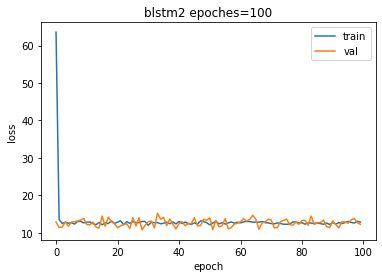

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('blstm2 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [63]:
#``lstm_fcn`` from the tf_models module
model_lstm_fcn= lstm_fcn(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm_fcn.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_lstm_fcn.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm_fcn = model_lstm_fcn.evaluate(val_dataset)
# update the result
results.update({'lstm_fcn': eval_lstm_fcn})

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_64 (Conv1D)             (None, 100, 128)     49280       ['input_20[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 128)    512         ['conv1d_64[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 128)     0           ['batch_normalization[0][0

11/11 [==============================] - 3s 232ms/step - loss: 6.6670 - mean_squared_error: 6.6670 - val_loss: 23.7955 - val_mean_squared_error: 23.7955
Epoch 25/100
11/11 [==============================] - 3s 242ms/step - loss: 6.3401 - mean_squared_error: 6.3401 - val_loss: 18.5629 - val_mean_squared_error: 18.5629
Epoch 26/100
11/11 [==============================] - 3s 242ms/step - loss: 6.1534 - mean_squared_error: 6.1534 - val_loss: 14.2204 - val_mean_squared_error: 14.2204
Epoch 27/100
11/11 [==============================] - 3s 216ms/step - loss: 5.8088 - mean_squared_error: 5.8088 - val_loss: 9.6265 - val_mean_squared_error: 9.6265
Epoch 28/100
11/11 [==============================] - 2s 225ms/step - loss: 5.2378 - mean_squared_error: 5.2378 - val_loss: 24.7597 - val_mean_squared_error: 24.7597
Epoch 29/100
11/11 [==============================] - 2s 218ms/step - loss: 5.3819 - mean_squared_error: 5.3819 - val_loss: 10.4322 - val_mean_squared_error: 10.4322
Epoch 30/100
11/11 

Epoch 74/100
11/11 [==============================] - 2s 220ms/step - loss: 1.5934 - mean_squared_error: 1.5934 - val_loss: 15.2791 - val_mean_squared_error: 15.2791
Epoch 75/100
11/11 [==============================] - 2s 209ms/step - loss: 1.6555 - mean_squared_error: 1.6555 - val_loss: 25.2340 - val_mean_squared_error: 25.2340
Epoch 76/100
11/11 [==============================] - 2s 212ms/step - loss: 1.8081 - mean_squared_error: 1.8081 - val_loss: 4.6199 - val_mean_squared_error: 4.6199
Epoch 77/100
11/11 [==============================] - 2s 219ms/step - loss: 1.8609 - mean_squared_error: 1.8609 - val_loss: 11.6629 - val_mean_squared_error: 11.6629
Epoch 78/100
11/11 [==============================] - 2s 206ms/step - loss: 1.6378 - mean_squared_error: 1.6378 - val_loss: 16.3617 - val_mean_squared_error: 16.3617
Epoch 79/100
11/11 [==============================] - 3s 237ms/step - loss: 1.4238 - mean_squared_error: 1.4238 - val_loss: 19.9249 - val_mean_squared_error: 19.9249
Epoch 

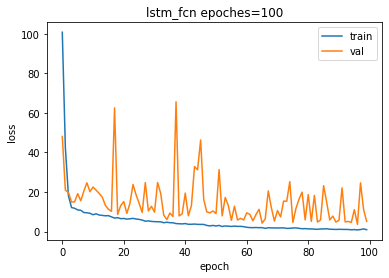

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_fcn epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [65]:
#``cnn_resnet`` from the tf_models module
model_cnn_resnet= cnn_resnet(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_cnn_resnet.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model_cnn_resnet.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_cnn_resnet = model_cnn_resnet.evaluate(val_dataset)
# update the result
results.update({'cnn_resnet': eval_cnn_resnet})

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_67 (Conv1D)             (None, 100, 64)      24640       ['input_21[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 100, 64)     256         ['conv1d_67[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 100, 64)      0           ['batch_normalization_3[0]

11/11 [==============================] - 7s 352ms/step - loss: 91.9775 - mean_squared_error: 91.9775 - val_loss: 145.7154 - val_mean_squared_error: 145.7154
Epoch 2/100
11/11 [==============================] - 4s 326ms/step - loss: 46.8540 - mean_squared_error: 46.8540 - val_loss: 90.4750 - val_mean_squared_error: 90.4750
Epoch 3/100
11/11 [==============================] - 4s 336ms/step - loss: 31.3102 - mean_squared_error: 31.3102 - val_loss: 60.4606 - val_mean_squared_error: 60.4606
Epoch 4/100
11/11 [==============================] - 4s 344ms/step - loss: 20.9390 - mean_squared_error: 20.9390 - val_loss: 27.2250 - val_mean_squared_error: 27.2250
Epoch 5/100
11/11 [==============================] - 4s 339ms/step - loss: 14.0831 - mean_squared_error: 14.0831 - val_loss: 24.0815 - val_mean_squared_error: 24.0815
Epoch 6/100
11/11 [==============================] - 4s 342ms/step - loss: 10.5405 - mean_squared_error: 10.5405 - val_loss: 12.8312 - val_mean_squared_error: 12.8312
Epoch 7/

11/11 [==============================] - 4s 343ms/step - loss: 0.9047 - mean_squared_error: 0.9047 - val_loss: 6.9734 - val_mean_squared_error: 6.9734
Epoch 51/100
11/11 [==============================] - 4s 335ms/step - loss: 0.8533 - mean_squared_error: 0.8533 - val_loss: 6.5389 - val_mean_squared_error: 6.5389
Epoch 52/100
11/11 [==============================] - 4s 345ms/step - loss: 0.7338 - mean_squared_error: 0.7338 - val_loss: 5.9752 - val_mean_squared_error: 5.9752
Epoch 53/100
11/11 [==============================] - 4s 344ms/step - loss: 0.8050 - mean_squared_error: 0.8050 - val_loss: 5.7276 - val_mean_squared_error: 5.7276
Epoch 54/100
11/11 [==============================] - 4s 331ms/step - loss: 0.7023 - mean_squared_error: 0.7023 - val_loss: 4.7320 - val_mean_squared_error: 4.7320
Epoch 55/100
11/11 [==============================] - 4s 337ms/step - loss: 0.5904 - mean_squared_error: 0.5904 - val_loss: 4.3918 - val_mean_squared_error: 4.3918
Epoch 56/100
11/11 [=========

Epoch 100/100
3/3 [==============================] - 0s 46ms/step - loss: 6.4675 - mean_squared_error: 6.4675


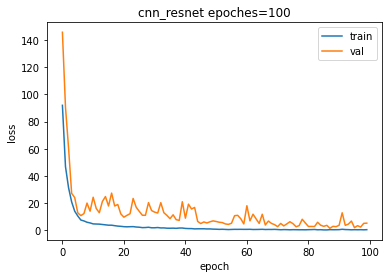

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn_resnet epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [68]:
results

{'cnn_lenet': [0.72774338722229, 0.72774338722229],
 'mlp4': [10.9797945022583, 10.9797945022583],
 'lstm1v0': [6.4763503074646, 6.4763503074646],
 'cnn_vgg': [0.7785779237747192, 0.7785779237747192],
 'lstm1': [14.305306434631348, 14.305306434631348],
 'lstm2': [12.756155967712402, 12.756155967712402],
 'blstm1': [12.261481285095215, 12.261481285095215],
 'blstm2': [12.069232940673828, 12.069232940673828],
 'lstm_fcn': [5.095458507537842, 5.095458507537842],
 'cnn_resnet': [6.467532157897949, 6.467532157897949]}